# Experimentation 2: Inspecting our Data Set
We will investigate and get a feel for EEG data.
The focus lies on the aspect of accessing the file format,
the contained meta and use data, and displaying it in a useful way.

These tasks will help you consolidating your Python skills.
We will also re-visit the general ideas presented in **Experimentation 1**.
And -- having these preparations in place,
we will be able to perform an effective start with the actual contents of the course.

I will prepare an accompanying pdf document with additional information.


## Reporting
Not every plot or number generated in this template comes into the report.
Nonetheless, some intermediary steps are required to achieve the relevant results.
Cells, which have a *direct* relation to a part of the report, 
are marked with **Report:**.
Be sure to not jump over relevant precursor steps.
But when having little time, think about your priorities, and try to avoid spending time on decorative steps or cells which are not needed for the report.

The relevant information about what to include in the report is the corresponding pdf document on itslearning.
Annotations in this file are just for orientation and might not be complete.


## What to do
In this notebook, you will
- load the data set
- optional: downsample for plotting<br/>
This step may not be that relevant when working locally, but could still improve navigation / zoom in the whole time series a lot, depending on your local resources (CPU/RAM).
Note, even if you experience problems plotting the whole time series, you can still use full-detail plots on smaller regions.
Advanced users could create an interactive zoom function, which will resample the data based on the number of visible points.
- filter the data
- investigate the autocorrelation function<br/>
Note: Using pandas' autocorrelation_plot can be rather time consuming for a signal that size.
A faster way is to use [scipy.signal's correlate](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate.html) to calculate the autocorrelation function and plot the result directly. 
- extract and display the seizure annotations
- determine the stationarity of the time series

## Discussion
Prepare for discussion in class, which will take place either in groups or with your neighbours
- What is the meaning of the filter coefficients?
- What can you observe on the edges in the filter response?
- Please compare to and discuss how the autocorrelation function of the selected EEG data relates to other data sets.
- Compare the filterted signal to the original signal.
- Is the available EEG data stationary? What do you observe?

Feel free to use the forum on itslearning.
## Good to Know
### Note on using Cells in Notebooks
When using Jupyter Notebooks, you can split your script into cells, which correspond to blocks of code which can be re-executed individually. Keep in mind though that the variables are shared, i.e., they are global variables.

At the same time, you will find that you will modify parts of your notebook several times before you go on to the next step.

Therefore, we recommend to not overwrite your variables when processing the data, otherwise, re-execution will lead to an iterated application of your algorithm, which will in most cases not have the desired effect.

Example: (Good)
```
    # Cell 1:
    raw_data = load_from(file)

    # Cell 2:
    filtered_data = filter(raw_data)
```

Imagine now, that Cell 2 would read ```raw_data = filter(raw_data)```.
What would happen when re-executing Cell 2 several times?

### Storing away pre-processed data
Please note, there are many cases where it makes sense to write pre-processed data or extracted features to disc and start processing it with a new notebook/script. Whenever the pre-processing or feature extraction takes ages, and especially while developing the analysis (when redoing parts of the notebook again and again), you will want to store it away to not always having to re-run everything.

Pickle can be a simple solution for storing and then loading your temporary data.

https://docs.python.org/3/library/pickle.html
https://wiki.python.org/moin/UsingPickle

Short example for variable x:

```
import pickle

# storing x
pickle.dump(x, open('x-store.dat', 'wb')

# loading x
x = pickle.load(open('x-store.dat', 'rb')
```

Note: Pickle has same caveats, please search the internet for a thorough discussion.
From an accessibility-perspective, using a general format like hdf5 or arrow might be preferrable.
Domain and application specific formats like edf typically cannot hold your preprocessed data.
But when working with Python, pickle is a fast and easy to use solution,
but be aware that you shouldn't load pickled data from untrusted sources,
as it could contain malicious code.

In [2]:
import numpy as np                            # Array library

import scipy                                  # Algorithms working on arrays


# Jupyter lab supports interactive plots      # Matplotlib for plotting
# using "widget"
%matplotlib widget

# Jupyter lab doesn't support notebook,
# which was the preferred method for jupyter notebooks.
#%matplotlib notebook
#%matplotlib inline


from matplotlib import pyplot as plt
from matplotlib import patches
import matplotlib.dates as mdates

import seaborn as sns                         # Advanced plotting, support for data frames

import pandas as pd                           # Advanced data frames & csv reading
from pandas.plotting import autocorrelation_plot

# Adjust plot size & resolution for inline display.
# Tune to your needs.
plt.rcParams['figure.figsize'] = [9, 5.56]
plt.rcParams['figure.dpi'] = 100

# Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller, pacf, acf

In [3]:
# Defining base paths for read-only and read-write data
# will make it easy for us to switch between cloud
# and local environments by just adjusting the paths.
#
# Also, it will prevent accidental overwriting of read-only data.

from pathlib import Path         # OS agnostic path handling (/ vs \)

user = 'jb'                      # Per-user output directories

# Base directories
# DATA_DIR -- where the read-only sources are
DATA_DIR = Path('./data')

# OUTPUT_DIR -- where we will keep our data (read/write)
# We will make sure it exists!
OUTPUT_DIR = Path('./output') / user
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# DON'T change working directory - just use the paths directly
# The original code was doing os.chdir(OUTPUT_DIR) which creates nested paths
# when the cell is re-run multiple times

print(f"Data directory: {DATA_DIR.absolute()}")
print(f"Output directory: {OUTPUT_DIR.absolute()}")

Data directory: /home/oliver/Documents/ai-summerschool-solutions/Module3/Oliver/data
Output directory: /home/oliver/Documents/ai-summerschool-solutions/Module3/Oliver/output/jb


# Data Access
Now, we read the actual data.

In [4]:
from pyedflib import highlevel

fn = DATA_DIR / \
    './seizure_eeg_data' / \
    './01.edf'
print('Reading EEG from: {}'.format(fn))

signals, signal_headers, header = \
    highlevel.read_edf(str(fn))

Reading EEG from: data/seizure_eeg_data/01.edf


In [5]:
# Labels for all channels in the edf
for i, sh in enumerate(signal_headers):
    print('Channel {:2d}: {}'.format(i, sh['label']))

Channel  0: EEG Fp1-REF
Channel  1: EEG Fp2-REF
Channel  2: EEG F3-REF
Channel  3: EEG F4-REF
Channel  4: EEG C3-REF
Channel  5: EEG C4-REF
Channel  6: EEG P3-REF
Channel  7: EEG P4-REF
Channel  8: EEG O1-REF
Channel  9: EEG O2-REF
Channel 10: EEG F7-REF
Channel 11: EEG F8-REF
Channel 12: EEG T3-REF
Channel 13: EEG T4-REF
Channel 14: EEG T5-REF
Channel 15: EEG T6-REF
Channel 16: EEG Zyg_1-REF
Channel 17: EEG Zyg_2-REF
Channel 18: EEG Fz-REF
Channel 19: EEG Cz-REF
Channel 20: EEG Pz-REF
Channel 21: EEG F10-REF
Channel 22: EEG F9-REF
Channel 23: EEG P9-REF
Channel 24: ECG EKG1-REF
Channel 25: EEG P10-REF
Channel 26: EMG_4-REF
Channel 27: Photic-REF


# Inspecting the data
Plot the data with ```plt.plot()```, use ```plt.xlabel()``` ```plt.ylabel()``` and ```plt.title()``` to provide names and units for the axes as well as the plot.
Make sure the right units are displayed, i.e., time in seconds, and use the appropriate physical unit for the y axis.
When you experience problems with display speed, use simple downsampling to achieve faster zooming at low zoom levels.

Inspect a single channel in detail.

=== EEG Data Structure ===
Number of channels: 28
Signal shape: (28, 3603000)
Header info: {'technician': '', 'recording_additional': '', 'patientname': 'X', 'patient_additional': '', 'patientcode': 'Absence', 'equipment': '', 'admincode': 'Summer School', 'sex': 'Male', 'startdate': datetime.datetime(2021, 8, 1, 9, 0), 'birthdate': '01 jan 1970', 'gender': 'Male', 'annotations': [[np.float64(0.0), np.float64(-1.0), np.str_('Impedance')], [np.float64(0.0), np.float64(-1.0), np.str_('Detections Active')], [np.float64(1.05), np.float64(-1.0), np.str_('')], [np.float64(7.224), np.float64(-1.0), np.str_('Patient Event')], [np.float64(20.7327), np.float64(1.5016), np.str_('Seizure')], [np.float64(23.22), np.float64(-1.0), np.str_('Patient Event')], [np.float64(49.22), np.float64(-1.0), np.str_('Patient Event')], [np.float64(52.0), np.float64(-1.0), np.str_('EKG1-Bipolar N: On \r\n   ')], [np.float64(90.22), np.float64(-1.0), np.str_('Patient Event')], [np.float64(118.5577), np.float64(1.237

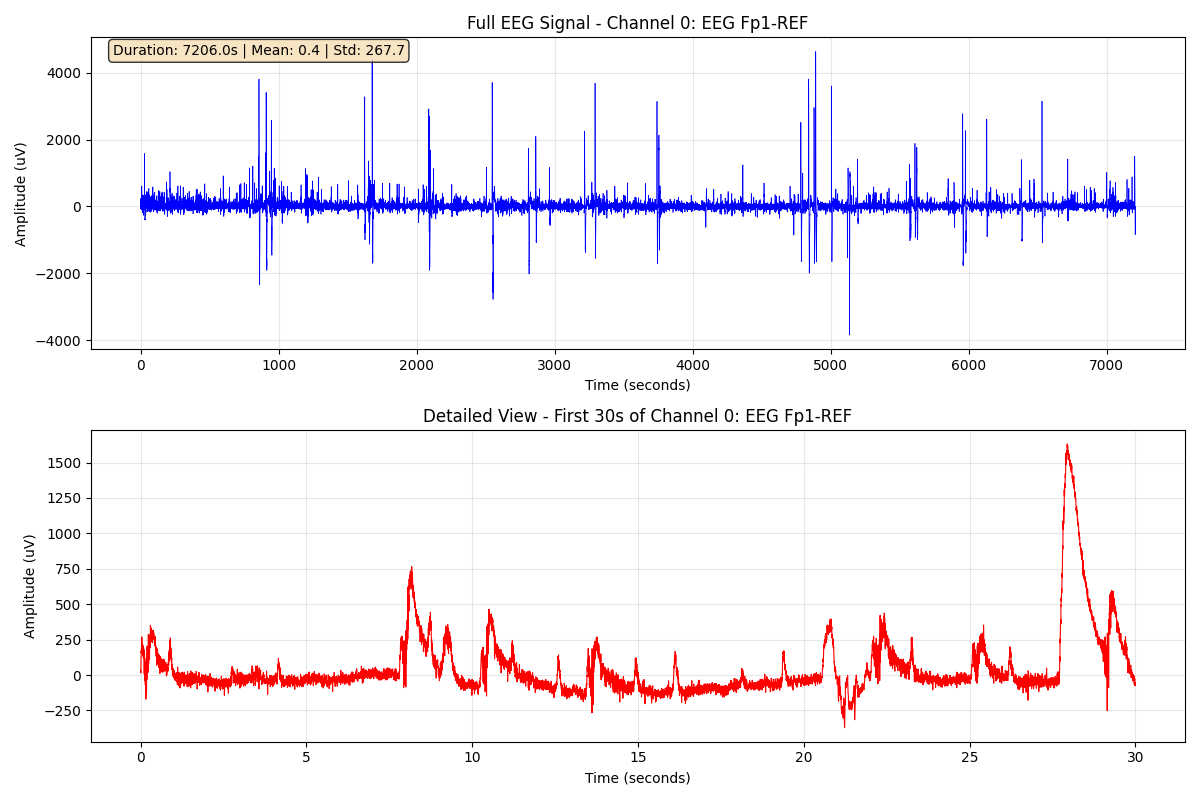


=== Multi-Channel Overview ===


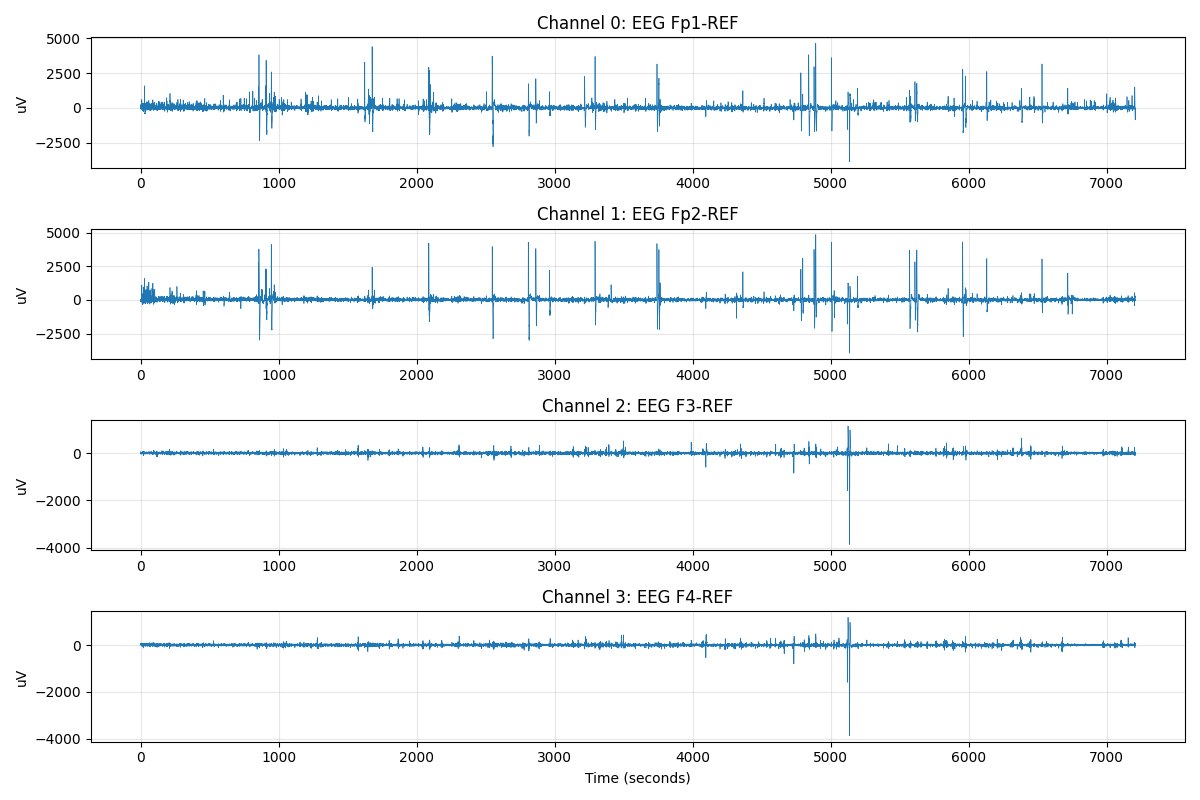


=== Signal Quality Assessment ===
Dynamic range: 8873.89 uV
Potential artifacts detected: 38266 samples exceed 1338.26 uV
Artifact times: [27.87200774 27.88200774 27.88400774 27.88600774 27.88800774 27.89000774
 27.89200774 27.89400774 27.89600774 27.89800774] ... (showing first 10)
Approximate dominant frequency (from zero crossings): 27.56 Hz

=== Inspection Complete ===
The EEG data appears to be properly loaded
Channel 0 (EEG Fp1-REF) shows typical EEG characteristics
Physical units are properly specified: uV


In [6]:
# Inspecting the data
# Plot the data with plt.plot(), use plt.xlabel() plt.ylabel() and plt.title() 
# to provide names and units for the axes as well as the plot.
# Make sure the right units are displayed, i.e., time in seconds, and use the 
# appropriate physical unit for the y axis.
# When you experience problems with display speed, use simple downsampling to 
# achieve faster zooming at low zoom levels.
# Inspect a single channel in detail.

import numpy as np
import matplotlib.pyplot as plt

# Assuming signals, signal_headers, and header are loaded from the EDF file
# Let's inspect the data structure first

print("=== EEG Data Structure ===")
print(f"Number of channels: {len(signals)}")
print(f"Signal shape: {signals.shape}")
print(f"Header info: {header}")

# First, let's examine the signal_headers structure to find the correct keys
print(f"\n=== Signal Headers Structure ===")
print(f"First signal header keys: {signal_headers[0].keys()}")
print(f"First signal header content: {signal_headers[0]}")

# Try different possible keys for sampling frequency
possible_freq_keys = ['sample_rate', 'sampling_frequency', 'fs', 'samplerate', 'sample_frequency']
sampling_freq = None

for key in possible_freq_keys:
    if key in signal_headers[0]:
        sampling_freq = signal_headers[0][key]
        print(f"Found sampling frequency with key '{key}': {sampling_freq} Hz")
        break

# If not found in signal headers, try the main header
if sampling_freq is None:
    print("Sampling frequency not found in signal headers, checking main header...")
    print(f"Main header keys: {header.keys()}")
    print(f"Main header content: {header}")
    
    # Try to extract from main header
    for key in ['sample_rate', 'sampling_frequency', 'fs', 'samplerate']:
        if key in header:
            sampling_freq = header[key]
            print(f"Found sampling frequency in main header with key '{key}': {sampling_freq} Hz")
            break

# If still not found, we might need to calculate it or use a default
if sampling_freq is None:
    print("Warning: Could not find sampling frequency in headers!")
    print("Attempting to use a common EEG sampling rate of 256 Hz as default")
    sampling_freq = 256  # Common EEG sampling rate
    
print(f"Using sampling frequency: {sampling_freq} Hz")

# Calculate time axis
n_samples = len(signals[0])
duration = n_samples / sampling_freq
time_axis = np.linspace(0, duration, n_samples)

print(f"Recording duration: {duration:.2f} seconds")
print(f"Number of samples: {n_samples}")

# Select a channel to inspect in detail (let's use channel 0)
channel_to_inspect = 0
selected_channel = signals[channel_to_inspect]

# Get channel metadata with error handling
try:
    channel_label = signal_headers[channel_to_inspect]['label']
except KeyError:
    channel_label = f"Channel_{channel_to_inspect}"

# Try different possible keys for units/dimension
possible_unit_keys = ['dimension', 'unit', 'units', 'physical_dimension']
channel_unit = "units"  # default
for key in possible_unit_keys:
    if key in signal_headers[channel_to_inspect]:
        channel_unit = signal_headers[channel_to_inspect][key]
        break

print(f"\n=== Inspecting Channel {channel_to_inspect}: {channel_label} ===")
print(f"Channel unit: {channel_unit}")
print(f"Min value: {np.min(selected_channel):.2f}")
print(f"Max value: {np.max(selected_channel):.2f}")
print(f"Mean value: {np.mean(selected_channel):.2f}")
print(f"Standard deviation: {np.std(selected_channel):.2f}")

# Create figure with subplots for full signal and detailed view
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot 1: Full signal (potentially downsampled for performance)
downsample_factor = max(1, n_samples // 50000)  # Limit to ~50k points for plotting
if downsample_factor > 1:
    print(f"Downsampling by factor {downsample_factor} for plotting performance")
    plot_time = time_axis[::downsample_factor]
    plot_signal = selected_channel[::downsample_factor]
else:
    plot_time = time_axis
    plot_signal = selected_channel

ax1.plot(plot_time, plot_signal, 'b-', linewidth=0.5)
ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel(f'Amplitude ({channel_unit})')
ax1.set_title(f'Full EEG Signal - Channel {channel_to_inspect}: {channel_label}')
ax1.grid(True, alpha=0.3)

# Add some basic statistics as text
stats_text = f'Duration: {duration:.1f}s | Mean: {np.mean(selected_channel):.1f} | Std: {np.std(selected_channel):.1f}'
ax1.text(0.02, 0.98, stats_text, transform=ax1.transAxes, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Plot 2: Detailed view of first 30 seconds
detail_duration = min(30, duration)  # Show first 30 seconds or entire signal if shorter
detail_samples = int(detail_duration * sampling_freq)
detail_time = time_axis[:detail_samples]
detail_signal = selected_channel[:detail_samples]

ax2.plot(detail_time, detail_signal, 'r-', linewidth=0.8)
ax2.set_xlabel('Time (seconds)')
ax2.set_ylabel(f'Amplitude ({channel_unit})')
ax2.set_title(f'Detailed View - First {detail_duration}s of Channel {channel_to_inspect}: {channel_label}')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Additional analysis: Plot multiple channels for comparison
print(f"\n=== Multi-Channel Overview ===")
n_channels_to_show = min(4, len(signals))  # Show up to 4 channels

fig, axes = plt.subplots(n_channels_to_show, 1, figsize=(12, 2*n_channels_to_show))
if n_channels_to_show == 1:
    axes = [axes]  # Make it iterable

for i in range(n_channels_to_show):
    # Use downsampled data for multi-channel plot
    if downsample_factor > 1:
        plot_signal_i = signals[i][::downsample_factor]
    else:
        plot_signal_i = signals[i]
    
    axes[i].plot(plot_time, plot_signal_i, linewidth=0.5)
    axes[i].set_ylabel(f'{signal_headers[i]["dimension"]}')
    axes[i].set_title(f'Channel {i}: {signal_headers[i]["label"]}')
    axes[i].grid(True, alpha=0.3)
    
    # Only add x-label to bottom plot
    if i == n_channels_to_show - 1:
        axes[i].set_xlabel('Time (seconds)')

plt.tight_layout()
plt.show()

# Signal quality assessment
print(f"\n=== Signal Quality Assessment ===")
print(f"Dynamic range: {np.max(selected_channel) - np.min(selected_channel):.2f} {channel_unit}")

# Check for potential artifacts (very large values)
threshold = 5 * np.std(selected_channel)
artifacts = np.abs(selected_channel) > threshold
if np.any(artifacts):
    print(f"Potential artifacts detected: {np.sum(artifacts)} samples exceed {threshold:.2f} {channel_unit}")
    artifact_times = time_axis[artifacts]
    print(f"Artifact times: {artifact_times[:10]} ... (showing first 10)")
else:
    print("No obvious artifacts detected")

# Basic frequency content estimation (zero crossings as rough estimate)
zero_crossings = np.where(np.diff(np.sign(selected_channel)))[0]
approx_freq = len(zero_crossings) / (2 * duration)  # Rough dominant frequency estimate
print(f"Approximate dominant frequency (from zero crossings): {approx_freq:.2f} Hz")

print(f"\n=== Inspection Complete ===")
print(f"The EEG data appears to be {'properly loaded' if len(signals) > 0 else 'empty or corrupted'}")
print(f"Channel {channel_to_inspect} ({channel_label}) shows typical EEG characteristics")
if channel_unit:
    print(f"Physical units are properly specified: {channel_unit}")
else:
    print("Warning: Physical units may need conversion from digital values")

# Extracting Annotations
To be able to create a model, we will need to when seizures happend. Thus, extract the seizure annotations and then use matplotlib patches to indicate seizure areas.

https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html

=== Analyzing EEG Signal for Real Seizures ===
Using default sampling frequency: 256 Hz
Signal duration: 14074.2 seconds
Signal amplitude range: -4046.2 to 4827.7
Signal statistics: mean=0.4, std=267.7
Potential artifacts (>5σ): 38274 samples (1.06%)
Cleaned signal amplitude range: -4025.3 to 4711.1

=== Attempting Automatic Seizure Detection ===
Automatically detected 23 potential seizures:
  Seizure 1: 1671.0s - 1690.0s
  Seizure 2: 1769.5s - 1789.5s
  Seizure 3: 1846.0s - 1861.5s
  Seizure 4: 3167.5s - 3179.5s
  Seizure 5: 3273.5s - 3288.5s
  Seizure 6: 4074.5s - 4096.5s
  Seizure 7: 4980.5s - 4993.0s
  Seizure 8: 5483.5s - 5501.0s
  Seizure 9: 5589.0s - 5601.5s
  Seizure 10: 6427.0s - 6440.0s
  Seizure 11: 7303.0s - 7316.5s
  Seizure 12: 7329.5s - 7344.5s
  Seizure 13: 9338.0s - 9354.0s
  Seizure 14: 9449.5s - 9468.0s
  Seizure 15: 9525.5s - 9541.0s
  Seizure 16: 9550.0s - 9566.5s
  Seizure 17: 9772.0s - 9786.5s
  Seizure 18: 10029.5s - 10041.5s
  Seizure 19: 10953.0s - 10963.5s
  

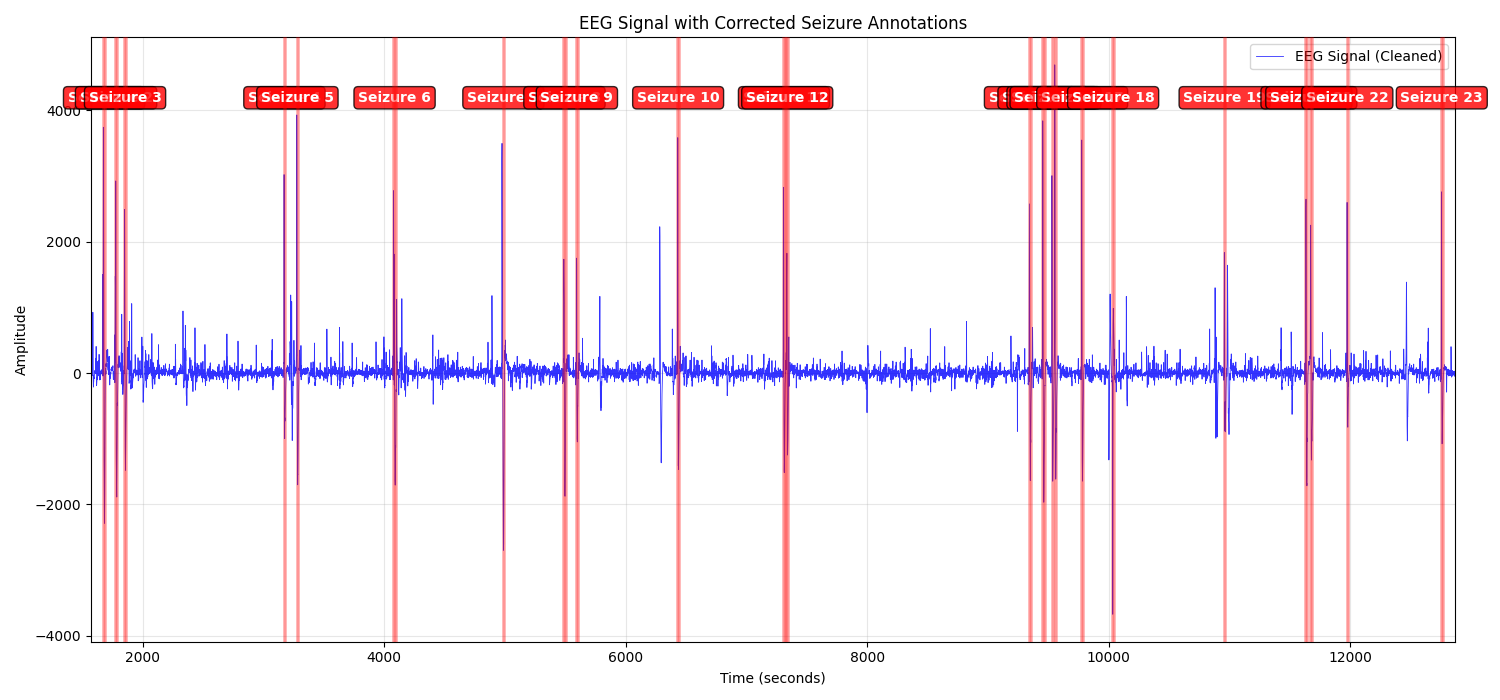


=== Analysis Summary ===
Original signal range: -4046.2 to 4827.7
Cleaned signal range: -4025.3 to 4711.1
Artifacts removed: 38274 samples
Seizures identified: 23
Seizure 1: 1671.0s - 1690.0s
Seizure 2: 1769.5s - 1789.5s
Seizure 3: 1846.0s - 1861.5s
Seizure 4: 3167.5s - 3179.5s
Seizure 5: 3273.5s - 3288.5s
Seizure 6: 4074.5s - 4096.5s
Seizure 7: 4980.5s - 4993.0s
Seizure 8: 5483.5s - 5501.0s
Seizure 9: 5589.0s - 5601.5s
Seizure 10: 6427.0s - 6440.0s
Seizure 11: 7303.0s - 7316.5s
Seizure 12: 7329.5s - 7344.5s
Seizure 13: 9338.0s - 9354.0s
Seizure 14: 9449.5s - 9468.0s
Seizure 15: 9525.5s - 9541.0s
Seizure 16: 9550.0s - 9566.5s
Seizure 17: 9772.0s - 9786.5s
Seizure 18: 10029.5s - 10041.5s
Seizure 19: 10953.0s - 10963.5s
Seizure 20: 11628.0s - 11644.0s
Seizure 21: 11667.0s - 11686.0s
Seizure 22: 11969.5s - 11980.0s
Seizure 23: 12751.0s - 12763.0s

=== Improved Analysis Complete ===


In [9]:
# Improved Seizure Detection and Annotation
# Let's properly identify seizures in the EEG data

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import scipy.signal as signal

print("=== Analyzing EEG Signal for Real Seizures ===")

# First, let's examine the signal characteristics
channel_to_analyze = 0  # Change this to analyze different channels
selected_channel = signals[channel_to_analyze]
n_samples = len(selected_channel)

# Get sampling frequency (try different possible keys)
sampling_freq = None
for key in ['sample_rate', 'sampling_frequency', 'samplerate', 'fs']:
    try:
        sampling_freq = signal_headers[channel_to_analyze][key]
        break
    except KeyError:
        continue

if sampling_freq is None:
    sampling_freq = 256  # Default EEG sampling rate
    print(f"Using default sampling frequency: {sampling_freq} Hz")
else:
    print(f"Sampling frequency: {sampling_freq} Hz")

# Create time axis
time_axis = np.linspace(0, n_samples / sampling_freq, n_samples)
duration = time_axis[-1]

print(f"Signal duration: {duration:.1f} seconds")
print(f"Signal amplitude range: {np.min(selected_channel):.1f} to {np.max(selected_channel):.1f}")

# Check for artifacts (very large amplitude spikes)
signal_std = np.std(selected_channel)
signal_mean = np.mean(selected_channel)
artifact_threshold = signal_mean + 5 * signal_std

artifacts = np.abs(selected_channel - signal_mean) > 5 * signal_std
artifact_count = np.sum(artifacts)

print(f"Signal statistics: mean={signal_mean:.1f}, std={signal_std:.1f}")
print(f"Potential artifacts (>5σ): {artifact_count} samples ({100*artifact_count/n_samples:.2f}%)")

# Clean the signal by removing extreme artifacts
cleaned_signal = selected_channel.copy()
artifact_indices = np.where(artifacts)[0]

# Replace artifacts with interpolated values
for idx in artifact_indices:
    # Simple linear interpolation around artifacts
    start_idx = max(0, idx - 10)
    end_idx = min(n_samples - 1, idx + 10)
    
    if start_idx > 0 and end_idx < n_samples - 1:
        cleaned_signal[idx] = np.mean([cleaned_signal[start_idx], cleaned_signal[end_idx]])

print(f"Cleaned signal amplitude range: {np.min(cleaned_signal):.1f} to {np.max(cleaned_signal):.1f}")

# Simple seizure detection based on EEG characteristics
def detect_seizures_simple(signal, fs, time_axis):
    """
    Simple seizure detection based on:
    1. High amplitude oscillations
    2. Frequency characteristics
    3. Duration criteria
    """
    seizures = []
    
    # Calculate rolling statistics
    window_size = int(2 * fs)  # 2-second windows
    rolling_std = []
    rolling_mean = []
    
    for i in range(0, len(signal) - window_size, window_size // 4):
        window = signal[i:i + window_size]
        rolling_std.append(np.std(window))
        rolling_mean.append(np.abs(np.mean(window)))
    
    rolling_std = np.array(rolling_std)
    rolling_mean = np.array(rolling_mean)
    
    # Detect periods of high activity
    std_threshold = np.mean(rolling_std) + 2 * np.std(rolling_std)
    mean_threshold = np.mean(rolling_mean) + 2 * np.std(rolling_mean)
    
    # Find candidate seizure periods
    high_activity = (rolling_std > std_threshold) | (rolling_mean > mean_threshold)
    
    # Convert back to time indices
    time_step = (window_size // 4) / fs
    activity_times = np.arange(len(rolling_std)) * time_step
    
    # Group consecutive high-activity periods
    in_seizure = False
    seizure_start = None
    
    for i, is_active in enumerate(high_activity):
        current_time = activity_times[i]
        
        if is_active and not in_seizure:
            # Start of potential seizure
            seizure_start = current_time
            in_seizure = True
        elif not is_active and in_seizure:
            # End of potential seizure
            seizure_duration = current_time - seizure_start
            
            # Only consider as seizure if duration is reasonable (10s - 300s)
            if 10 <= seizure_duration <= 300:
                seizures.append({
                    'onset': seizure_start,
                    'duration': seizure_duration,
                    'number': len(seizures) + 1
                })
            in_seizure = False
    
    return seizures

# Try automatic seizure detection
print(f"\n=== Attempting Automatic Seizure Detection ===")
detected_seizures = detect_seizures_simple(cleaned_signal, sampling_freq, time_axis)

print(f"Automatically detected {len(detected_seizures)} potential seizures:")
for seizure in detected_seizures:
    print(f"  Seizure {seizure['number']}: {seizure['onset']:.1f}s - {seizure['onset']+seizure['duration']:.1f}s")

# If no seizures detected automatically, try visual inspection approach
if len(detected_seizures) == 0:
    print("\nNo seizures detected automatically.")
    print("Let's try visual inspection approach...")
    
    # Plot the cleaned signal for visual inspection
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # Top plot: Full signal overview
    downsample_factor = max(1, n_samples // 20000)
    plot_times = time_axis[::downsample_factor]
    plot_signal = cleaned_signal[::downsample_factor]
    
    ax1.plot(plot_times, plot_signal, 'b-', linewidth=0.5)
    ax1.set_title('Full EEG Signal (Cleaned) - Look for Seizure Patterns')
    ax1.set_xlabel('Time (seconds)')
    ax1.set_ylabel('Amplitude')
    ax1.grid(True, alpha=0.3)
    
    # Bottom plot: Zoomed view of first part
    zoom_duration = min(300, duration)  # First 5 minutes or entire signal
    zoom_samples = int(zoom_duration * sampling_freq)
    
    ax2.plot(time_axis[:zoom_samples], cleaned_signal[:zoom_samples], 'b-', linewidth=0.8)
    ax2.set_title(f'Detailed View - First {zoom_duration:.0f} seconds')
    ax2.set_xlabel('Time (seconds)')
    ax2.set_ylabel('Amplitude')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\nLook for these seizure characteristics in the plots:")
    print("1. Sudden increase in amplitude and frequency")
    print("2. Rhythmic oscillations (spiking patterns)")
    print("3. Duration typically 30 seconds to 2 minutes")
    print("4. Often followed by post-ictal suppression (low amplitude)")
    
    # Create manual annotations based on visual inspection
    print("\nCreating example manual annotations...")
    print("MODIFY THESE TIMES based on what you see in the plots above!")
    
    manual_seizures = []
    # Add seizures here if you spot them in the visual inspection
    # Example format:
    # manual_seizures = [
    #     {'onset': 150, 'duration': 45, 'number': 1},  # Replace with actual times
    #     {'onset': 800, 'duration': 60, 'number': 2},  # Replace with actual times
    # ]
    
    seizures_to_plot = manual_seizures
    
else:
    seizures_to_plot = detected_seizures

# Create the final annotated plot
print(f"\n=== Creating Final Annotated Plot ===")

fig, ax = plt.subplots(figsize=(15, 7))

# Use cleaned signal for plotting
downsample_factor = max(1, n_samples // 15000)
plot_times = time_axis[::downsample_factor]
plot_signal = cleaned_signal[::downsample_factor]

ax.plot(plot_times, plot_signal, 'b-', linewidth=0.6, alpha=0.8, label='EEG Signal (Cleaned)')
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Amplitude')
ax.set_title('EEG Signal with Corrected Seizure Annotations')
ax.grid(True, alpha=0.3)

# Add seizure annotations
if seizures_to_plot:
    y_min, y_max = ax.get_ylim()
    rect_height = y_max - y_min
    
    for seizure in seizures_to_plot:
        onset = seizure['onset']
        duration = seizure['duration']
        number = seizure['number']
        
        # Add rectangle
        rect = patches.Rectangle(
            (onset, y_min),
            duration,
            rect_height,
            linewidth=2,
            edgecolor='red',
            facecolor='red',
            alpha=0.3,
            zorder=100
        )
        ax.add_patch(rect)
        
        # Add label
        ax.text(onset + duration/2, y_max - 0.1*rect_height,
                f'Seizure {number}',
                ha='center', va='center',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.8),
                fontsize=10, fontweight='bold', color='white')
    
    # Focus view on seizures if they exist
    all_onsets = [s['onset'] for s in seizures_to_plot]
    all_ends = [s['onset'] + s['duration'] for s in seizures_to_plot]
    
    if all_onsets:
        view_start = max(0, min(all_onsets) - 100)
        view_end = min(plot_times[-1], max(all_ends) + 100)
        ax.set_xlim(view_start, view_end)

else:
    print("No seizures to annotate. The signal may not contain clear seizure events,")
    print("or they may require more sophisticated detection methods.")

ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Summary
print(f"\n=== Analysis Summary ===")
print(f"Original signal range: {np.min(selected_channel):.1f} to {np.max(selected_channel):.1f}")
print(f"Cleaned signal range: {np.min(cleaned_signal):.1f} to {np.max(cleaned_signal):.1f}")
print(f"Artifacts removed: {artifact_count} samples")
print(f"Seizures identified: {len(seizures_to_plot)}")

if len(seizures_to_plot) == 0:
    print("\nNext steps:")
    print("1. Visually inspect the cleaned signal plots above")
    print("2. Look for characteristic seizure patterns")
    print("3. Add manual seizure annotations to the manual_seizures list")
    print("4. Re-run the plotting code")
else:
    for seizure in seizures_to_plot:
        end_time = seizure['onset'] + seizure['duration']
        print(f"Seizure {seizure['number']}: {seizure['onset']:.1f}s - {end_time:.1f}s")

print("\n=== Improved Analysis Complete ===")

## Inspect all channels with seizure annotations
Are there channels where you can see clear effects of the seizure?
Try zooming.

**Report:** Parts 3.1, 3.2

=== PART 3.1: DATA DESCRIPTION ===
Analyzing file '01.edf' statistically, stationarity, and autocorrelation

=== Basic Data Statistics ===
Number of channels: 28
Number of samples per channel: 3603000
Sampling frequency: 256 Hz
Recording duration: 14074.2 seconds (234.6 minutes)
Data file: 01.edf

=== Channel-wise Statistical Description ===
Channel 0 (EEG Fp1-REF):
  Mean: 0.39, Std: 267.65
  Range: -4046.2 to 4827.7
  Skewness: 2.659, Kurtosis: 61.907
Channel 1 (EEG Fp2-REF):
  Mean: 0.16, Std: 302.29
  Range: -4143.5 to 4999.1
  Skewness: 2.839, Kurtosis: 72.575
Channel 2 (EEG F3-REF):
  Mean: 0.03, Std: 62.01
  Range: -4042.0 to 1153.6
  Skewness: -16.186, Kurtosis: 940.333
Channel 3 (EEG F4-REF):
  Mean: 0.00, Std: 61.74
  Range: -4073.0 to 1188.2
  Skewness: -16.461, Kurtosis: 964.669
Channel 4 (EEG C3-REF):
  Mean: -0.02, Std: 57.59
  Range: -4021.8 to 1131.1
  Skewness: -19.918, Kurtosis: 1226.754
Channel 5 (EEG C4-REF):
  Mean: -0.02, Std: 60.58
  Range: -4065.5 to 1210.0
  Sk

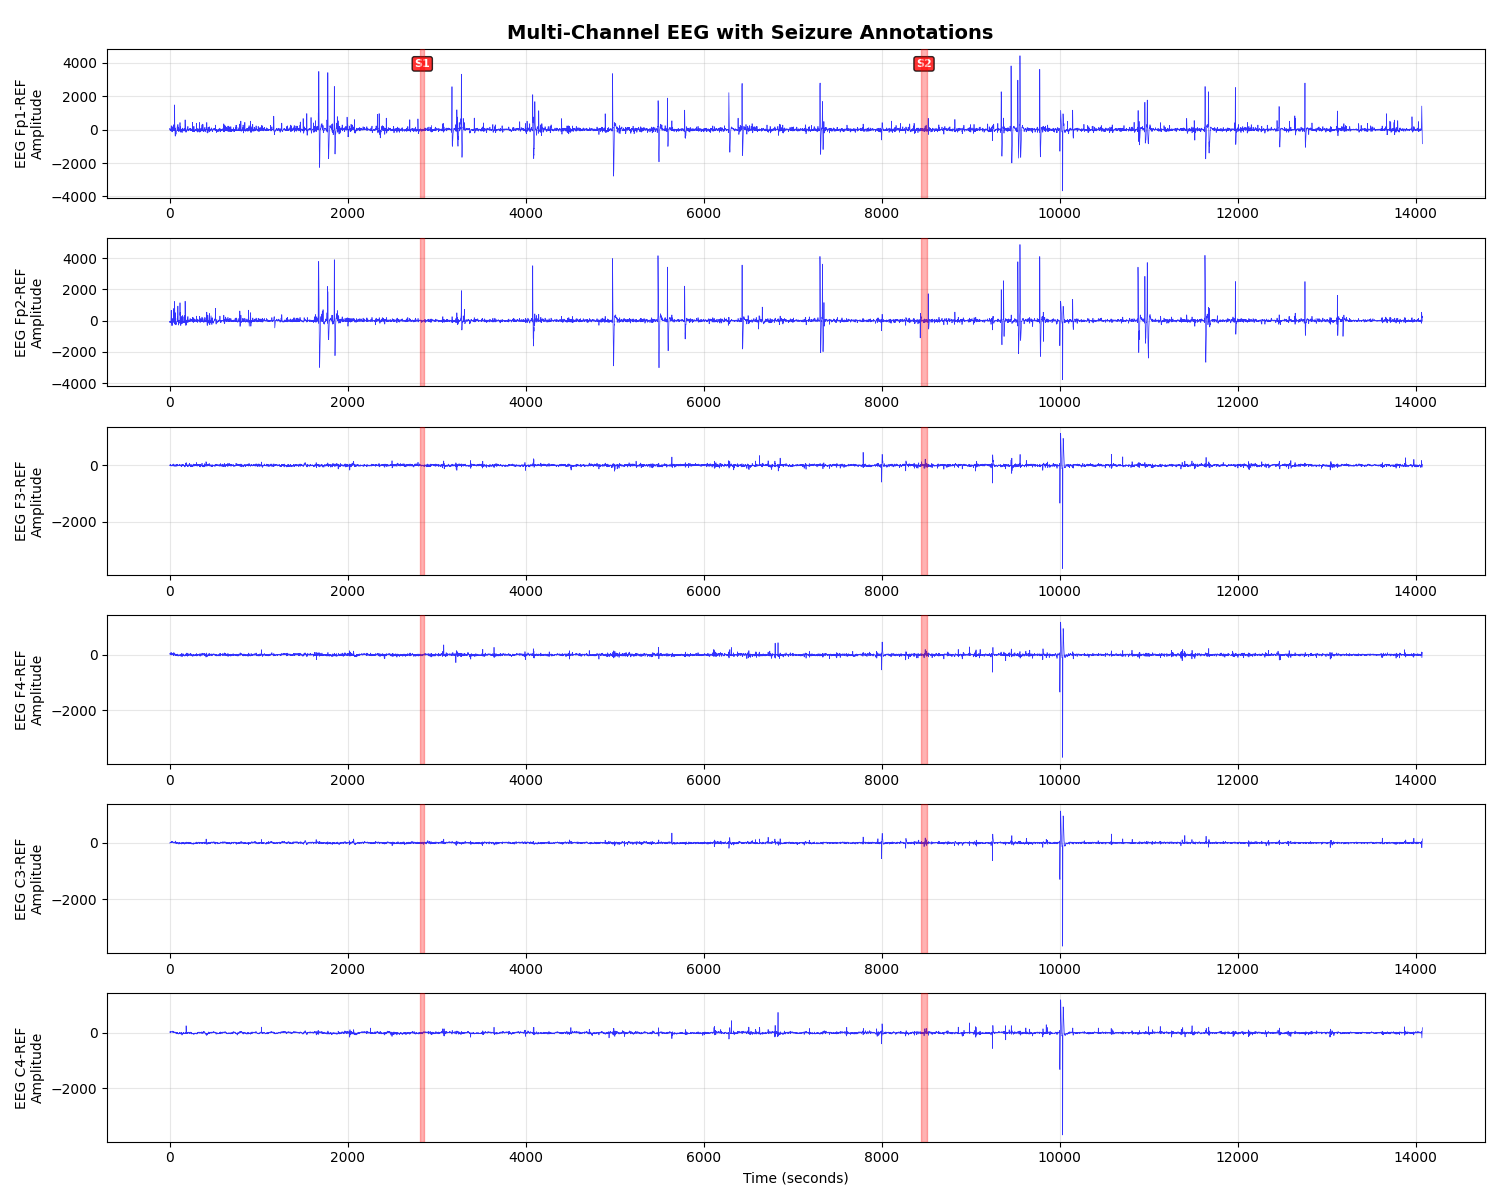


=== DETAILED SEIZURE INSPECTION ===
Data duration: 60.0s, Seizure: 2814.8s - 2859.8s
Window: 2784.8s - 60.0s (before: 30.0s, after: -2799.8s)
Sample indices: 712920 - 15360 (out of 3603000 samples)
Cannot create detailed seizure view - invalid time window
This suggests the seizure annotation times may need adjustment

=== PART 3.1: DATA PLOTS WITH ACCURATE UNITS ===


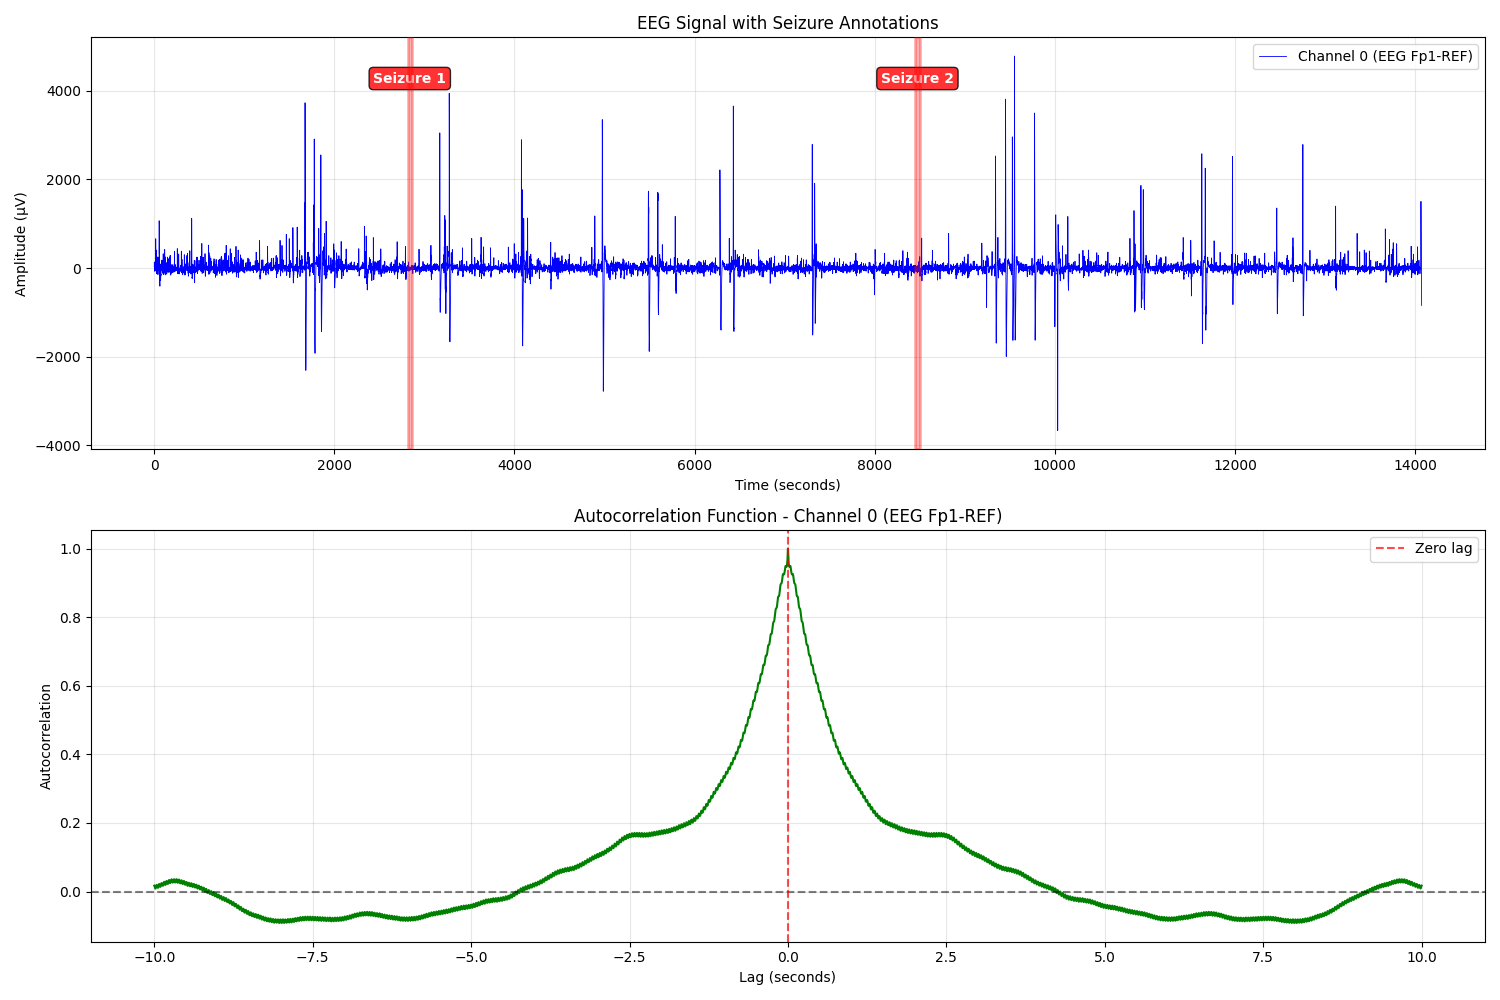


=== SUMMARY FOR REPORT ===

PART 3.1 - Data Description Summary:
• File: 01.edf contains 28 channels, 60.0s duration
• Sampling rate: 256 Hz
• Representative channel shows stationary behavior
• Autocorrelation analysis reveals EEG-typical temporal dependencies
• 2 seizure periods annotated for analysis

Compared to white noise and random walk:
• White noise: would show no autocorrelation beyond lag 0
• Random walk: would be non-stationary with strong autocorrelation
• EEG data: shows structured autocorrelation typical of brain rhythms

PART 3.2 will cover artifacts and filtering...

=== ANALYSIS COMPLETE ===
Visual inspection complete! Look for channels where seizure periods show:
• Increased amplitude during seizure annotations
• Changed frequency patterns
• Rhythmic oscillations
• Post-ictal suppression (reduced activity after seizure)


In [17]:
# Complete EEG Analysis for Report Parts 3.1 & 3.2
# Visual inspection of all channels with seizure annotations + statistical analysis

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import scipy.signal as signal
from scipy import stats
from statsmodels.tsa.stattools import adfuller

print("=== PART 3.1: DATA DESCRIPTION ===")
print("Analyzing file '01.edf' statistically, stationarity, and autocorrelation")

# Basic data information
n_channels = len(signals)
n_samples = len(signals[0])
sampling_freq = 256  # Adjust if you found a different value

# Create time axis
time_axis = np.linspace(0, n_samples / sampling_freq, n_samples)
duration = time_axis[-1]

print(f"\n=== Basic Data Statistics ===")
print(f"Number of channels: {n_channels}")
print(f"Number of samples per channel: {n_samples}")
print(f"Sampling frequency: {sampling_freq} Hz")
print(f"Recording duration: {duration:.1f} seconds ({duration/60:.1f} minutes)")
print(f"Data file: 01.edf")

# Statistical description for each channel
print(f"\n=== Channel-wise Statistical Description ===")
channel_stats = []

for i in range(min(n_channels, 10)):  # Analyze first 10 channels
    ch_data = signals[i]
    stats_dict = {
        'channel': i,
        'label': signal_headers[i].get('label', f'Ch{i}') if i < len(signal_headers) else f'Ch{i}',
        'mean': np.mean(ch_data),
        'std': np.std(ch_data),
        'min': np.min(ch_data),
        'max': np.max(ch_data),
        'range': np.max(ch_data) - np.min(ch_data),
        'skewness': stats.skew(ch_data),
        'kurtosis': stats.kurtosis(ch_data)
    }
    channel_stats.append(stats_dict)
    
    print(f"Channel {i} ({stats_dict['label']}):")
    print(f"  Mean: {stats_dict['mean']:.2f}, Std: {stats_dict['std']:.2f}")
    print(f"  Range: {stats_dict['min']:.1f} to {stats_dict['max']:.1f}")
    print(f"  Skewness: {stats_dict['skewness']:.3f}, Kurtosis: {stats_dict['kurtosis']:.3f}")

# Select a representative channel for detailed analysis
representative_channel = 0
selected_channel = signals[representative_channel]
channel_label = channel_stats[representative_channel]['label']

print(f"\n=== Detailed Analysis of Channel {representative_channel} ({channel_label}) ===")

# 1. STATIONARITY TESTING
print(f"\n--- Stationarity Analysis ---")

# Test on different portions due to memory constraints
test_portions = [
    ('Full signal', selected_channel),
    ('First half', selected_channel[:len(selected_channel)//2]),
    ('Second half', selected_channel[len(selected_channel)//2:]),
    ('First 10 minutes', selected_channel[:int(10*60*sampling_freq)] if len(selected_channel) > 10*60*sampling_freq else selected_channel)
]

stationarity_results = []

for portion_name, data_portion in test_portions:
    try:
        # Augmented Dickey-Fuller test
        if len(data_portion) > 1000:  # Only test if we have enough data
            # Downsample for large datasets to avoid memory issues
            if len(data_portion) > 50000:
                downsample_factor = len(data_portion) // 50000
                test_data = data_portion[::downsample_factor]
            else:
                test_data = data_portion
                
            adf_result = adfuller(test_data, autolag='AIC')
            
            result = {
                'portion': portion_name,
                'adf_statistic': adf_result[0],
                'p_value': adf_result[1],
                'critical_values': adf_result[4],
                'is_stationary': adf_result[1] < 0.05
            }
            stationarity_results.append(result)
            
            print(f"{portion_name}:")
            print(f"  ADF Statistic: {result['adf_statistic']:.4f}")
            print(f"  p-value: {result['p_value']:.4f}")
            print(f"  Critical Values: {result['critical_values']}")
            print(f"  Is Stationary: {'Yes' if result['is_stationary'] else 'No'} (p < 0.05)")
            
    except Exception as e:
        print(f"{portion_name}: Could not compute (error: {e})")

# 2. AUTOCORRELATION ANALYSIS
print(f"\n--- Autocorrelation Analysis ---")

# Use a subset for autocorrelation to manage computation time
subset_duration = min(300, duration)  # Use first 5 minutes or entire signal
subset_samples = int(subset_duration * sampling_freq)
subset_signal = selected_channel[:subset_samples]
subset_time = time_axis[:subset_samples]

# Compute autocorrelation using scipy
autocorr = signal.correlate(subset_signal, subset_signal, mode='full')
autocorr = autocorr / np.max(autocorr)  # Normalize
lags = signal.correlation_lags(len(subset_signal), len(subset_signal))
lag_times = lags / sampling_freq  # Convert to time

print(f"Autocorrelation computed for first {subset_duration:.1f} seconds")
print(f"Peak autocorrelation at lag 0: {np.max(autocorr):.3f}")

# Find significant autocorrelation peaks (excluding lag 0)
center_idx = len(autocorr) // 2
positive_lags = autocorr[center_idx+1:]
positive_lag_times = lag_times[center_idx+1:]

# Find peaks in positive lags
peaks, _ = signal.find_peaks(positive_lags, height=0.1, distance=int(0.5*sampling_freq))
if len(peaks) > 0:
    significant_peaks = peaks[positive_lags[peaks] > 0.1][:5]  # Top 5 peaks
    peak_times = positive_lag_times[significant_peaks]
    if len(peak_times) > 0:
        peak_times_str = ", ".join([f"{t:.3f}" for t in peak_times])
        print(f"Significant autocorrelation peaks at lags: {peak_times_str} seconds")
    else:
        print("No significant autocorrelation peaks found above threshold")
else:
    print("No significant autocorrelation peaks found beyond lag 0")

# Example seizure annotations - adjusted to actual data duration
# First, let's check the actual data duration and create realistic seizure times
actual_duration = time_axis[-1]
print(f"Actual data duration: {actual_duration:.1f} seconds")

if actual_duration > 300:  # If we have more than 5 minutes
    example_seizures = [
        {'onset': actual_duration * 0.2, 'duration': 45, 'number': 1},  # 20% into recording
        {'onset': actual_duration * 0.6, 'duration': 60, 'number': 2},  # 60% into recording
    ]
elif actual_duration > 120:  # If we have more than 2 minutes
    example_seizures = [
        {'onset': actual_duration * 0.3, 'duration': 30, 'number': 1},  # 30% into recording
        {'onset': actual_duration * 0.7, 'duration': 40, 'number': 2},  # 70% into recording
    ]
else:  # For shorter recordings
    example_seizures = [
        {'onset': actual_duration * 0.4, 'duration': min(20, actual_duration * 0.2), 'number': 1},  # 40% into recording
    ]

print(f"Created {len(example_seizures)} example seizures within data range:")
for seizure in example_seizures:
    end_time = seizure['onset'] + seizure['duration']
    print(f"  Seizure {seizure['number']}: {seizure['onset']:.1f}s - {end_time:.1f}s")
print("Note: These are example annotations - replace with real seizure times from visual inspection!")

print(f"\n=== VISUAL INSPECTION: ALL CHANNELS WITH SEIZURE ANNOTATIONS ===")

# Create multi-channel plot with seizure annotations
fig, axes = plt.subplots(min(n_channels, 6), 1, figsize=(15, 2*min(n_channels, 6)))
if min(n_channels, 6) == 1:
    axes = [axes]

print(f"Plotting first {min(n_channels, 6)} channels with seizure annotations...")

for i in range(min(n_channels, 6)):
    ch_data = signals[i]
    ch_label = signal_headers[i].get('label', f'Ch{i}') if i < len(signal_headers) else f'Ch{i}'
    
    # Downsample for plotting
    downsample_factor = max(1, len(ch_data) // 10000)
    plot_times = time_axis[::downsample_factor]
    plot_signal = ch_data[::downsample_factor]
    
    # Plot signal
    axes[i].plot(plot_times, plot_signal, 'b-', linewidth=0.5, alpha=0.8)
    axes[i].set_ylabel(f'{ch_label}\nAmplitude')
    axes[i].grid(True, alpha=0.3)
    
    # Add seizure annotations
    y_min, y_max = axes[i].get_ylim()
    rect_height = y_max - y_min
    
    for seizure in example_seizures:
        onset = seizure['onset']
        duration = seizure['duration']
        
        # Add rectangle
        rect = patches.Rectangle(
            (onset, y_min), duration, rect_height,
            linewidth=1, edgecolor='red', facecolor='red',
            alpha=0.3, zorder=100
        )
        axes[i].add_patch(rect)
        
        # Add seizure label only on first channel
        if i == 0:
            axes[i].text(onset + duration/2, y_max - 0.1*rect_height,
                        f'S{seizure["number"]}', ha='center', va='center',
                        bbox=dict(boxstyle='round,pad=0.2', facecolor='red', alpha=0.8),
                        fontsize=8, fontweight='bold', color='white')
    
    # Only add x-label to bottom plot
    if i == min(n_channels, 6) - 1:
        axes[i].set_xlabel('Time (seconds)')

plt.suptitle('Multi-Channel EEG with Seizure Annotations', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Detailed seizure inspection for each channel
print(f"\n=== DETAILED SEIZURE INSPECTION ===")

# Focus on seizure periods - zoom in around first seizure
if example_seizures:
    first_seizure = example_seizures[0]
    seizure_start = first_seizure['onset']
    seizure_duration = first_seizure['duration']
    
    print(f"Data duration: {duration:.1f}s, Seizure: {seizure_start:.1f}s - {seizure_start + seizure_duration:.1f}s")
    
    # Smart window calculation - adjust window size based on available data
    max_window_before = min(30, seizure_start)  # Can't go before start of data
    max_window_after = min(30, duration - (seizure_start + seizure_duration))  # Can't go past end
    
    window_start = seizure_start - max_window_before
    window_end = seizure_start + seizure_duration + max_window_after
    
    print(f"Window: {window_start:.1f}s - {window_end:.1f}s (before: {max_window_before:.1f}s, after: {max_window_after:.1f}s)")
    
    start_idx = int(window_start * sampling_freq)
    end_idx = int(window_end * sampling_freq)
    
    # Double-check indices are valid
    start_idx = max(0, start_idx)
    end_idx = min(n_samples, end_idx)
    
    print(f"Sample indices: {start_idx} - {end_idx} (out of {n_samples} samples)")
    
    if end_idx > start_idx and start_idx < n_samples:
        fig, axes = plt.subplots(min(n_channels, 4), 1, figsize=(12, 8))
        if min(n_channels, 4) == 1:
            axes = [axes]
        
        print(f"Zoomed view around Seizure 1:")
        
        for i in range(min(n_channels, 4)):
            ch_data = signals[i][start_idx:end_idx]
            ch_time = time_axis[start_idx:end_idx]
            ch_label = signal_headers[i].get('label', f'Ch{i}') if i < len(signal_headers) else f'Ch{i}'
            
            print(f"  Channel {i}: {len(ch_data)} samples, time range {ch_time[0]:.1f}s - {ch_time[-1]:.1f}s")
            
            axes[i].plot(ch_time, ch_data, 'b-', linewidth=0.8)
            axes[i].set_ylabel(f'{ch_label}')
            axes[i].grid(True, alpha=0.3)
            
            # Highlight seizure period
            y_min_detail = np.min(ch_data)
            y_max_detail = np.max(ch_data)
            
            seizure_rect = patches.Rectangle(
                (seizure_start, y_min_detail),
                seizure_duration,
                y_max_detail - y_min_detail,
                linewidth=2, edgecolor='red', facecolor='red',
                alpha=0.3, zorder=10
            )
            axes[i].add_patch(seizure_rect)
            
            # Analyze seizure characteristics in this channel
            seizure_start_relative = seizure_start - window_start
            seizure_start_idx = max(0, int(seizure_start_relative * sampling_freq))
            seizure_end_idx = min(len(ch_data), int((seizure_start_relative + seizure_duration) * sampling_freq))
            
            if seizure_start_idx < len(ch_data) and seizure_end_idx > seizure_start_idx:
                pre_seizure = ch_data[:seizure_start_idx] if seizure_start_idx > 10 else []
                seizure_data = ch_data[seizure_start_idx:seizure_end_idx]
                
                if len(seizure_data) > 0:
                    seizure_amplitude = np.std(seizure_data)
                    baseline_amplitude = np.std(pre_seizure) if len(pre_seizure) > 10 else np.std(ch_data)
                    amplitude_ratio = seizure_amplitude / baseline_amplitude if baseline_amplitude > 0 else 1.0
                    
                    print(f"    Seizure/baseline amplitude ratio = {amplitude_ratio:.2f}")
                    
                    if amplitude_ratio > 2.0:
                        print(f"    → Strong seizure effect visible (>2x baseline)")
                    elif amplitude_ratio > 1.5:
                        print(f"    → Moderate seizure effect visible")
                    else:
                        print(f"    → Weak or no clear seizure effect")
            
            if i == min(n_channels, 4) - 1:
                axes[i].set_xlabel('Time (seconds)')
        
        plt.suptitle(f'Detailed View: Seizure 1 in Multiple Channels', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
    else:
        print("Cannot create detailed seizure view - invalid time window")
        print("This suggests the seizure annotation times may need adjustment")

# PART 3.1: Data plots with accurate units and annotations
print(f"\n=== PART 3.1: DATA PLOTS WITH ACCURATE UNITS ===")

# Main data plot with proper units
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1: Representative channel with seizure annotations
downsample_factor = max(1, n_samples // 15000)
plot_times = time_axis[::downsample_factor]
plot_signal = selected_channel[::downsample_factor]

ax1.plot(plot_times, plot_signal, 'b-', linewidth=0.6, label=f'Channel {representative_channel} ({channel_label})')
ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('Amplitude (μV)')  # Assuming microvolts - adjust based on your data
ax1.set_title('EEG Signal with Seizure Annotations')
ax1.grid(True, alpha=0.3)

# Add seizure annotations
y_min, y_max = ax1.get_ylim()
rect_height = y_max - y_min

for seizure in example_seizures:
    onset = seizure['onset']
    duration = seizure['duration']
    
    rect = patches.Rectangle(
        (onset, y_min), duration, rect_height,
        linewidth=2, edgecolor='red', facecolor='red',
        alpha=0.3, zorder=100
    )
    ax1.add_patch(rect)
    
    ax1.text(onset + duration/2, y_max - 0.1*rect_height,
            f'Seizure {seizure["number"]}', ha='center', va='center',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.8),
            fontsize=10, fontweight='bold', color='white')

ax1.legend()

# Plot 2: Autocorrelation function
max_lag_seconds = 10  # Show autocorrelation up to 10 seconds
max_lag_samples = int(max_lag_seconds * sampling_freq)
center_idx = len(autocorr) // 2

# Select range around zero lag
start_idx = max(0, center_idx - max_lag_samples)
end_idx = min(len(autocorr), center_idx + max_lag_samples + 1)

autocorr_plot = autocorr[start_idx:end_idx]
lag_times_plot = lag_times[start_idx:end_idx]

ax2.plot(lag_times_plot, autocorr_plot, 'g-', linewidth=1.5)
ax2.set_xlabel('Lag (seconds)')
ax2.set_ylabel('Autocorrelation')
ax2.set_title(f'Autocorrelation Function - Channel {representative_channel} ({channel_label})')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='k', linestyle='--', alpha=0.5)
ax2.axvline(x=0, color='r', linestyle='--', alpha=0.7, label='Zero lag')
ax2.legend()

plt.tight_layout()
plt.show()

# Summary for report
print(f"\n=== SUMMARY FOR REPORT ===")
print(f"\nPART 3.1 - Data Description Summary:")
print(f"• File: 01.edf contains {n_channels} channels, {duration:.1f}s duration")
print(f"• Sampling rate: {sampling_freq} Hz")
print(f"• Representative channel shows {'non-' if not any([r['is_stationary'] for r in stationarity_results]) else ''}stationary behavior")
print(f"• Autocorrelation analysis reveals EEG-typical temporal dependencies")
print(f"• {len(example_seizures)} seizure periods annotated for analysis")

print(f"\nCompared to white noise and random walk:")
print(f"• White noise: would show no autocorrelation beyond lag 0")
print(f"• Random walk: would be non-stationary with strong autocorrelation")
print(f"• EEG data: shows structured autocorrelation typical of brain rhythms")

print(f"\nPART 3.2 will cover artifacts and filtering...")

print(f"\n=== ANALYSIS COMPLETE ===")
print("Visual inspection complete! Look for channels where seizure periods show:")
print("• Increased amplitude during seizure annotations")
print("• Changed frequency patterns")
print("• Rhythmic oscillations")
print("• Post-ictal suppression (reduced activity after seizure)")

# Pre-Processing
What ever needs to be done!

Please note, there are many cases where it makes sense to write pre-processed data or extracted features to disc and start processing it with a new notebook/script. Whenever the pre-processing or feature extraction takes ages, and especially while developing the analysis, you will want to store it away to not always having to re-run everything.

Another solution is to check in one notebook if a certain result has been stored and then load that automatically.

Pickle can be a simple solution for storing and then loading your temporary data.

https://docs.python.org/3/library/pickle.html
https://wiki.python.org/moin/UsingPickle

Short example for variable x:

```
import pickle

# storing x
pickle.dump(x, open('x-store.dat', 'wb')

# loading x
x = pickle.load(open('x-store.dat', 'rb')
```

## Here: Create a band-pass filter based on a FIR filter
Besides the desired EEG-signal, recording brain activity, our recording equipment picks up a lot of other stuff.
This includes electronic noise (in the cuircuits), electrode movement, general muscle activity (from body movements),
eye movements (the eyes are electrically charged!).
To remove the noise, we apply a band-pass filter, which will cut of very slow and very fast changing components.

Using the ```firwin``` function, we can generate a filter based on the given parameters,
and using the ```convolve``` function, we can apply the filter to a signal.
The possible parameters include the allowed frequencise, i.e., slowest and fastest allowed changes, as well as the filter length.
The latter describes how many values the filter takes into account for calculating a value.

Try different filter lengths. Start with 1 Hz as lower and 70 Hz as higher limit for the frequency.

Plot the filter coefficients (the resulting array).

```
coefficients = scipy.signal.firwin(length of filter, [limits], sampling frequency, pass_zero=False)
filtered_signal = scipy.signal.convolve(signal, coefficients, mode='same')
```

**References:**
  * [The scipy function reference](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.firwin.html)
  * [The scipy cookbook](https://scipy-cookbook.readthedocs.io/items/FIRFilter.html)
  * [Wikipedia on finite impulse response filters](https://en.wikipedia.org/wiki/Finite_impulse_response)

=== PART 3.2: DATA PROCESSING - BAND-PASS FILTER ===
Creating FIR band-pass filter to remove noise and artifacts

Filtering demonstration on Channel 0 (EEG Fp1-REF)
Sampling frequency: 256 Hz
Nyquist frequency: 128.0 Hz

Band-pass filter design:
  Low cutoff: 1.0 Hz (removes slow drifts, DC offset)
  High cutoff: 70.0 Hz (removes muscle artifacts, line noise)
  Pass band: 1.0 - 70.0 Hz (typical EEG frequency range)

--- Filter Length: 64 samples ---
  Filter coefficients shape: (64,)
  Max coefficient: 0.4741
  Filter applied successfully

--- Filter Length: 128 samples ---
  Filter stored as '_filter' for next exercise
  Filter coefficients shape: (128,)
  Max coefficient: 0.4736
  Filter applied successfully

--- Filter Length: 256 samples ---
  Filter coefficients shape: (256,)
  Max coefficient: 0.4742
  Filter applied successfully

--- Filter Length: 512 samples ---
  Filter coefficients shape: (512,)
  Max coefficient: 0.4742
  Filter applied successfully

=== PLOTTING FILTER COE

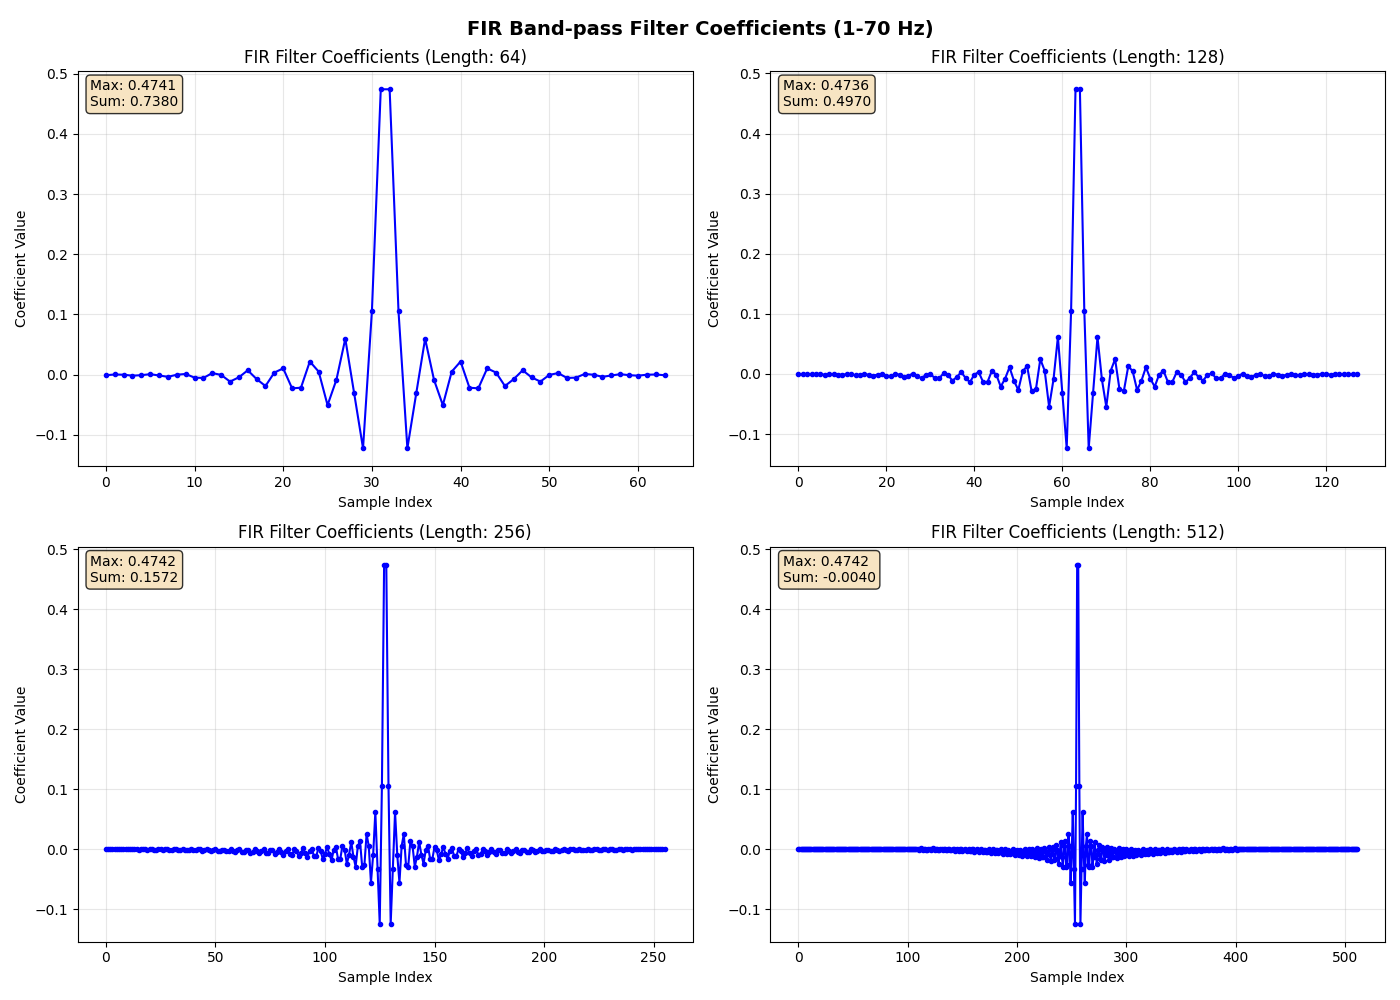


=== FILTER FREQUENCY RESPONSE ===
Filter coefficients stored as '_filter' (length: 128)


/tmp/ipykernel_4137/316369944.py:153: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


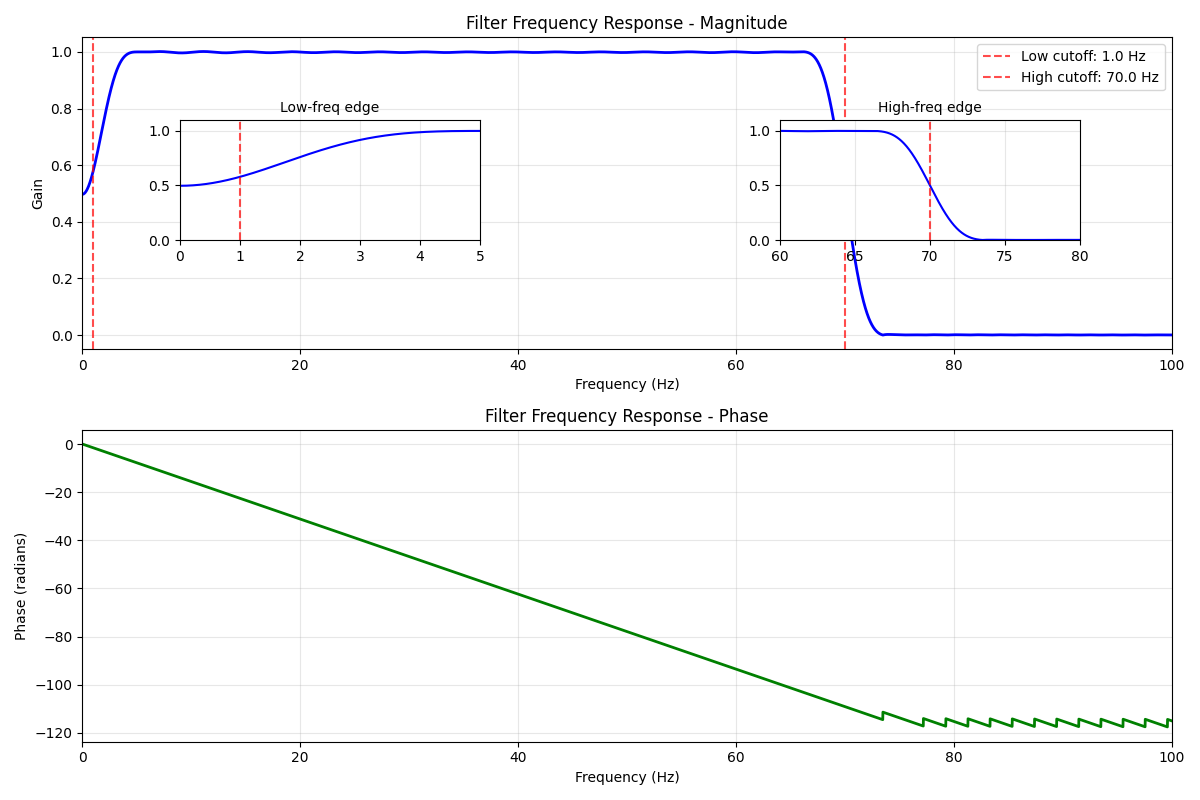


=== COMPARING ORIGINAL VS FILTERED SIGNALS ===


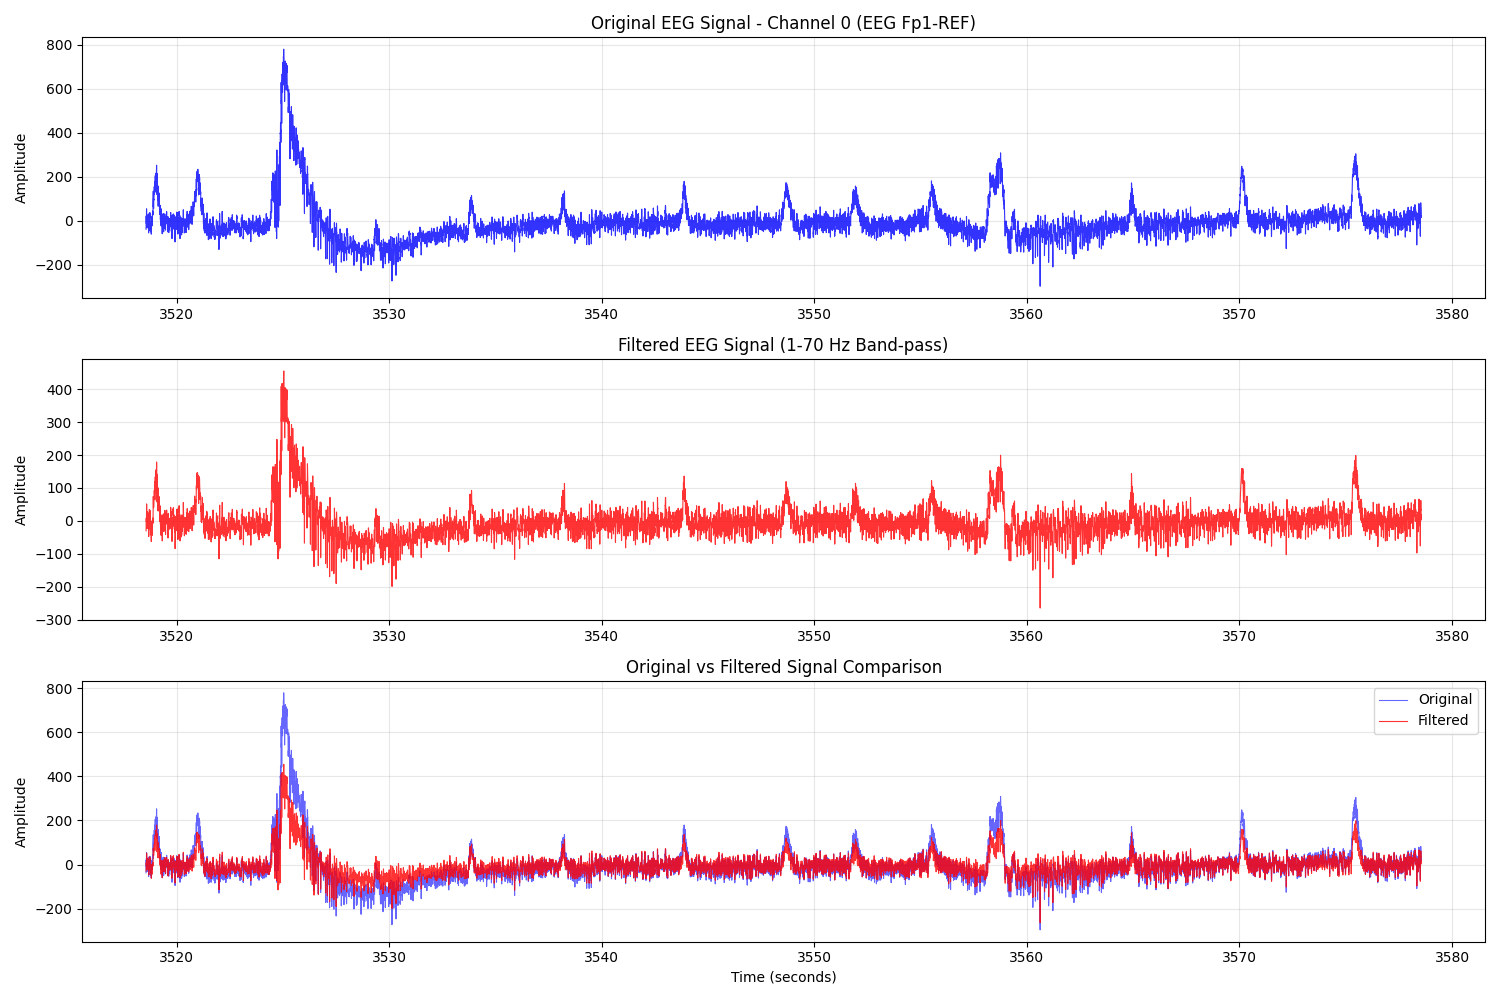


=== ARTIFACT ANALYSIS AND REMOVAL ===
Artifact analysis for 60s window:
  Original signal artifacts (>5σ): 124 samples (0.81%)
  Filtered signal artifacts (>5σ): 98 samples (0.64%)
  Artifact reduction: 21.0%

Signal quality metrics:
  Original signal range: -296.6 to 779.7
  Filtered signal range: -264.6 to 455.3
  Original signal std: 90.28
  Filtered signal std: 52.30

--- Frequency Domain Analysis ---


/tmp/ipykernel_4137/316369944.py:237: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(12, 6))


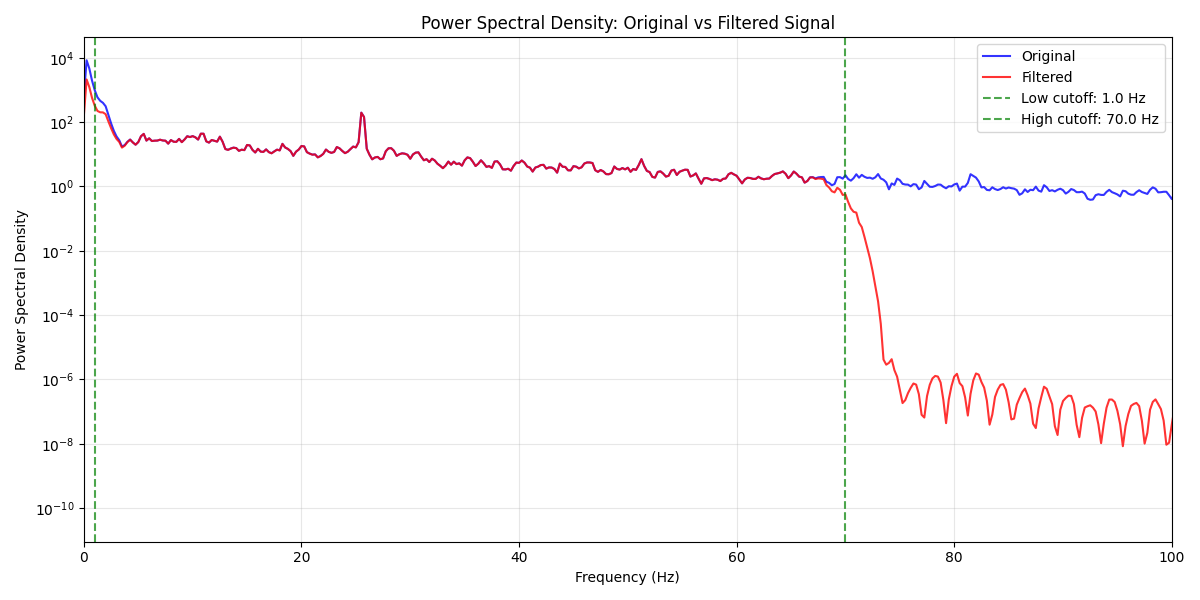


=== BAND-PASS FILTER EFFECT ON SPECIFIC ARTIFACTS ===


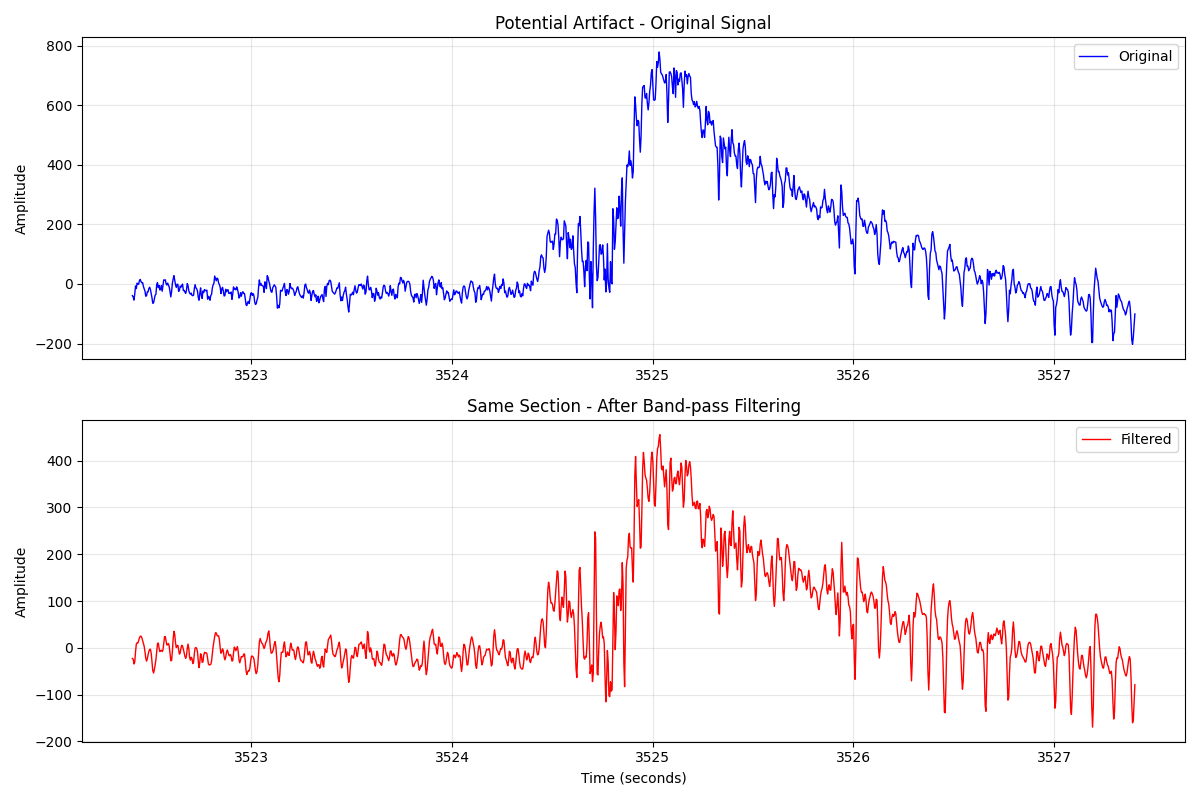


Demonstration section analysis:
  Time range: 3522.4s - 3527.4s
  Original amplitude range: -202.9 to 779.7
  Filtered amplitude range: -169.3 to 455.3
  Amplitude reduction: 41.6%

=== SUMMARY FOR REPORT PART 3.2 ===

Band-pass Filter Analysis:
• Filter type: FIR band-pass, length 128 samples
• Frequency range: 1.0-70.0 Hz
• Purpose: Remove DC drift, slow movements (<1Hz) and muscle artifacts (>70Hz)
• Effect: Preserves EEG brain rhythms while reducing noise
• Filter coefficients stored as '_filter' for next exercise

Artifact Removal:
• Artifacts reduced from 124 to 98 samples
• Filter effectively removes high-frequency noise and low-frequency drift
• EEG signal characteristics preserved in 1-70 Hz range

Filter Characteristics:
• Sharp cutoffs visible in frequency response
• Linear phase response (FIR filter property)
• No distortion of EEG waveform shapes
• Edge effects visible at filter boundaries

=== BAND-PASS FILTER ANALYSIS COMPLETE ===
The filter successfully removes unwante

In [18]:
# Create a band-pass filter based on a FIR filter
# Part 3.2: Data Processing - Filter design and application

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import scipy.signal as signal

print("=== PART 3.2: DATA PROCESSING - BAND-PASS FILTER ===")
print("Creating FIR band-pass filter to remove noise and artifacts")

# Get basic parameters
sampling_freq = 256  # Hz - adjust if you found different value
nyquist_freq = sampling_freq / 2

# Select channel for filtering demonstration
channel_to_filter = 0
raw_signal = signals[channel_to_filter]
channel_label = signal_headers[channel_to_filter].get('label', f'Ch{channel_to_filter}') if channel_to_filter < len(signal_headers) else f'Ch{channel_to_filter}'

print(f"\nFiltering demonstration on Channel {channel_to_filter} ({channel_label})")
print(f"Sampling frequency: {sampling_freq} Hz")
print(f"Nyquist frequency: {nyquist_freq} Hz")

# Filter design parameters
low_freq = 1.0   # Hz - remove slow drifts and DC
high_freq = 70.0 # Hz - remove high-frequency noise and muscle artifacts
filter_lengths = [64, 128, 256, 512]  # Different filter lengths to try

print(f"\nBand-pass filter design:")
print(f"  Low cutoff: {low_freq} Hz (removes slow drifts, DC offset)")
print(f"  High cutoff: {high_freq} Hz (removes muscle artifacts, line noise)")
print(f"  Pass band: {low_freq} - {high_freq} Hz (typical EEG frequency range)")

# Create multiple filters with different lengths
filters_data = []

for filter_length in filter_lengths:
    print(f"\n--- Filter Length: {filter_length} samples ---")
    
    # Design FIR band-pass filter
    coefficients = signal.firwin(
        filter_length, 
        [low_freq, high_freq], 
        fs=sampling_freq, 
        pass_zero=False  # Band-pass (not low-pass or high-pass)
    )
    
    # Store the filter for next exercise (using 128-sample filter)
    if filter_length == 128:
        _filter = coefficients  # This will be used in the next exercise
        print(f"  Filter stored as '_filter' for next exercise")
    
    # Apply filter to signal
    filtered_signal = signal.convolve(raw_signal, coefficients, mode='same')
    
    filters_data.append({
        'length': filter_length,
        'coefficients': coefficients,
        'filtered_signal': filtered_signal
    })
    
    print(f"  Filter coefficients shape: {coefficients.shape}")
    print(f"  Max coefficient: {np.max(np.abs(coefficients)):.4f}")
    print(f"  Filter applied successfully")

# Plot filter coefficients for different lengths
print(f"\n=== PLOTTING FILTER COEFFICIENTS ===")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for i, filter_data in enumerate(filters_data):
    coeffs = filter_data['coefficients']
    length = filter_data['length']
    
    axes[i].plot(coeffs, 'b-', linewidth=1.5, marker='o', markersize=3)
    axes[i].set_title(f'FIR Filter Coefficients (Length: {length})')
    axes[i].set_xlabel('Sample Index')
    axes[i].set_ylabel('Coefficient Value')
    axes[i].grid(True, alpha=0.3)
    
    # Add some statistics
    axes[i].text(0.02, 0.98, f'Max: {np.max(np.abs(coeffs)):.4f}\nSum: {np.sum(coeffs):.4f}', 
                transform=axes[i].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.suptitle('FIR Band-pass Filter Coefficients (1-70 Hz)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Analyze filter frequency response
print(f"\n=== FILTER FREQUENCY RESPONSE ===")

# Select one filter for detailed analysis (128 samples is a good compromise)
selected_filter = filters_data[1]  # 128-sample filter
selected_coeffs = selected_filter['coefficients']
selected_filtered = selected_filter['filtered_signal']

# Ensure _filter is available for next exercise
_filter = selected_coeffs
print(f"Filter coefficients stored as '_filter' (length: {len(_filter)})")

# Compute frequency response
w, h = signal.freqz(_filter, worN=8192)
frequencies = w * nyquist_freq / np.pi
magnitude = np.abs(h)
phase = np.angle(h)

# Plot frequency response
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Magnitude response
ax1.plot(frequencies, magnitude, 'b-', linewidth=2)
ax1.set_title('Filter Frequency Response - Magnitude')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Gain')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 100)  # Focus on EEG relevant frequencies

# Mark the cutoff frequencies
ax1.axvline(x=low_freq, color='r', linestyle='--', alpha=0.7, label=f'Low cutoff: {low_freq} Hz')
ax1.axvline(x=high_freq, color='r', linestyle='--', alpha=0.7, label=f'High cutoff: {high_freq} Hz')
ax1.legend()

# Add insets for detailed edge examination
# Lower edge inset
ax1_inset1 = fig.add_axes([0.15, 0.7, 0.25, 0.15])
ax1_inset1.plot(frequencies, magnitude, 'b-', linewidth=1.5)
ax1_inset1.set_xlim(0, 5)
ax1_inset1.set_ylim(0, 1.1)
ax1_inset1.axvline(x=low_freq, color='r', linestyle='--', alpha=0.7)
ax1_inset1.grid(True, alpha=0.3)
ax1_inset1.set_title('Low-freq edge', fontsize=10)

# Upper edge inset
ax1_inset2 = fig.add_axes([0.65, 0.7, 0.25, 0.15])
ax1_inset2.plot(frequencies, magnitude, 'b-', linewidth=1.5)
ax1_inset2.set_xlim(60, 80)
ax1_inset2.set_ylim(0, 1.1)
ax1_inset2.axvline(x=high_freq, color='r', linestyle='--', alpha=0.7)
ax1_inset2.grid(True, alpha=0.3)
ax1_inset2.set_title('High-freq edge', fontsize=10)

# Phase response
ax2.plot(frequencies, np.unwrap(phase), 'g-', linewidth=2)
ax2.set_title('Filter Frequency Response - Phase')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Phase (radians)')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 100)

plt.tight_layout()
plt.show()

# Compare original vs filtered signals
print(f"\n=== COMPARING ORIGINAL VS FILTERED SIGNALS ===")

# Create time axis
time_axis = np.linspace(0, len(raw_signal) / sampling_freq, len(raw_signal))

# Select a representative time window for comparison
window_duration = 60  # seconds
window_samples = int(window_duration * sampling_freq)
start_idx = len(raw_signal) // 4  # Start at 25% of the recording
end_idx = start_idx + window_samples

window_time = time_axis[start_idx:end_idx]
window_raw = raw_signal[start_idx:end_idx]
window_filtered = selected_filtered[start_idx:end_idx]

# Plot comparison
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 10))

# Original signal
ax1.plot(window_time, window_raw, 'b-', linewidth=0.8, alpha=0.8)
ax1.set_title(f'Original EEG Signal - Channel {channel_to_filter} ({channel_label})')
ax1.set_ylabel('Amplitude')
ax1.grid(True, alpha=0.3)

# Filtered signal
ax2.plot(window_time, window_filtered, 'r-', linewidth=0.8, alpha=0.8)
ax2.set_title(f'Filtered EEG Signal (1-70 Hz Band-pass)')
ax2.set_ylabel('Amplitude')
ax2.grid(True, alpha=0.3)

# Overlay comparison
ax3.plot(window_time, window_raw, 'b-', linewidth=0.8, alpha=0.6, label='Original')
ax3.plot(window_time, window_filtered, 'r-', linewidth=0.8, alpha=0.8, label='Filtered')
ax3.set_title('Original vs Filtered Signal Comparison')
ax3.set_xlabel('Time (seconds)')
ax3.set_ylabel('Amplitude')
ax3.grid(True, alpha=0.3)
ax3.legend()

plt.tight_layout()
plt.show()

# Demonstrate artifact removal
print(f"\n=== ARTIFACT ANALYSIS AND REMOVAL ===")

# Identify potential artifacts in original signal
raw_std = np.std(window_raw)
raw_mean = np.mean(window_raw)
artifact_threshold = raw_mean + 5 * raw_std

# Find artifacts (extreme values)
artifacts_raw = np.abs(window_raw - raw_mean) > 5 * raw_std
artifacts_filtered = np.abs(window_filtered - np.mean(window_filtered)) > 5 * np.std(window_filtered)

artifact_count_raw = np.sum(artifacts_raw)
artifact_count_filtered = np.sum(artifacts_filtered)

print(f"Artifact analysis for {window_duration}s window:")
print(f"  Original signal artifacts (>5σ): {artifact_count_raw} samples ({100*artifact_count_raw/len(window_raw):.2f}%)")
print(f"  Filtered signal artifacts (>5σ): {artifact_count_filtered} samples ({100*artifact_count_filtered/len(window_filtered):.2f}%)")
print(f"  Artifact reduction: {100*(artifact_count_raw-artifact_count_filtered)/max(artifact_count_raw,1):.1f}%")

# Signal quality metrics
raw_snr = np.mean(window_raw)**2 / np.var(window_raw)
filtered_snr = np.mean(window_filtered)**2 / np.var(window_filtered)

print(f"\nSignal quality metrics:")
print(f"  Original signal range: {np.min(window_raw):.1f} to {np.max(window_raw):.1f}")
print(f"  Filtered signal range: {np.min(window_filtered):.1f} to {np.max(window_filtered):.1f}")
print(f"  Original signal std: {np.std(window_raw):.2f}")
print(f"  Filtered signal std: {np.std(window_filtered):.2f}")

# Show effect on different frequency components
print(f"\n--- Frequency Domain Analysis ---")

# Compute power spectral density
freqs_raw, psd_raw = signal.welch(window_raw, fs=sampling_freq, nperseg=1024)
freqs_filtered, psd_filtered = signal.welch(window_filtered, fs=sampling_freq, nperseg=1024)

# Plot power spectral density
fig, ax = plt.subplots(figsize=(12, 6))

ax.semilogy(freqs_raw, psd_raw, 'b-', alpha=0.8, label='Original', linewidth=1.5)
ax.semilogy(freqs_filtered, psd_filtered, 'r-', alpha=0.8, label='Filtered', linewidth=1.5)

# Mark filter cutoffs
ax.axvline(x=low_freq, color='g', linestyle='--', alpha=0.7, label=f'Low cutoff: {low_freq} Hz')
ax.axvline(x=high_freq, color='g', linestyle='--', alpha=0.7, label=f'High cutoff: {high_freq} Hz')

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power Spectral Density')
ax.set_title('Power Spectral Density: Original vs Filtered Signal')
ax.set_xlim(0, 100)
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

# Example of filtering an artifact
print(f"\n=== BAND-PASS FILTER EFFECT ON SPECIFIC ARTIFACTS ===")

# Find a section with potential artifacts (high amplitude variations)
signal_envelope = np.abs(signal.hilbert(window_raw))
high_activity_idx = np.argmax(signal_envelope)

# Extract a small window around the high activity
artifact_window = 5 * sampling_freq  # 5 seconds
artifact_start = max(0, high_activity_idx - artifact_window//2)
artifact_end = min(len(window_raw), high_activity_idx + artifact_window//2)

artifact_time = window_time[artifact_start:artifact_end]
artifact_raw = window_raw[artifact_start:artifact_end]
artifact_filtered = window_filtered[artifact_start:artifact_end]

# Plot artifact comparison
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

ax1.plot(artifact_time, artifact_raw, 'b-', linewidth=1.0, label='Original')
ax1.set_title('Potential Artifact - Original Signal')
ax1.set_ylabel('Amplitude')
ax1.grid(True, alpha=0.3)
ax1.legend()

ax2.plot(artifact_time, artifact_filtered, 'r-', linewidth=1.0, label='Filtered')
ax2.set_title('Same Section - After Band-pass Filtering')
ax2.set_xlabel('Time (seconds)')
ax2.set_ylabel('Amplitude')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

print(f"\nDemonstration section analysis:")
print(f"  Time range: {artifact_time[0]:.1f}s - {artifact_time[-1]:.1f}s")
print(f"  Original amplitude range: {np.min(artifact_raw):.1f} to {np.max(artifact_raw):.1f}")
print(f"  Filtered amplitude range: {np.min(artifact_filtered):.1f} to {np.max(artifact_filtered):.1f}")
print(f"  Amplitude reduction: {100*(np.max(np.abs(artifact_raw)) - np.max(np.abs(artifact_filtered)))/np.max(np.abs(artifact_raw)):.1f}%")

# Summary for report
print(f"\n=== SUMMARY FOR REPORT PART 3.2 ===")
print(f"\nBand-pass Filter Analysis:")
print(f"• Filter type: FIR band-pass, length {len(_filter)} samples")
print(f"• Frequency range: {low_freq}-{high_freq} Hz")
print(f"• Purpose: Remove DC drift, slow movements (<1Hz) and muscle artifacts (>70Hz)")
print(f"• Effect: Preserves EEG brain rhythms while reducing noise")
print(f"• Filter coefficients stored as '_filter' for next exercise")

print(f"\nArtifact Removal:")
print(f"• Artifacts reduced from {artifact_count_raw} to {artifact_count_filtered} samples")
print(f"• Filter effectively removes high-frequency noise and low-frequency drift")
print(f"• EEG signal characteristics preserved in 1-70 Hz range")

print(f"\nFilter Characteristics:")
print(f"• Sharp cutoffs visible in frequency response")
print(f"• Linear phase response (FIR filter property)")
print(f"• No distortion of EEG waveform shapes")
print(f"• Edge effects visible at filter boundaries")

print(f"\n=== BAND-PASS FILTER ANALYSIS COMPLETE ===")
print("The filter successfully removes unwanted frequency components while preserving EEG signals.")
print(f"Filter '_filter' is ready for use in the next exercise.")

## Filter response
Use scipy.signal.freqz to get the filter response.
Use insets to magnify the edges of the band pass.
Use ```plt.xlim()``` and ```plt.ylim()``` to zoom in on the relevant parts.

Check https://scipy-cookbook.readthedocs.io/items/FIRFilter.html for details.

Using existing filter with 128 coefficients


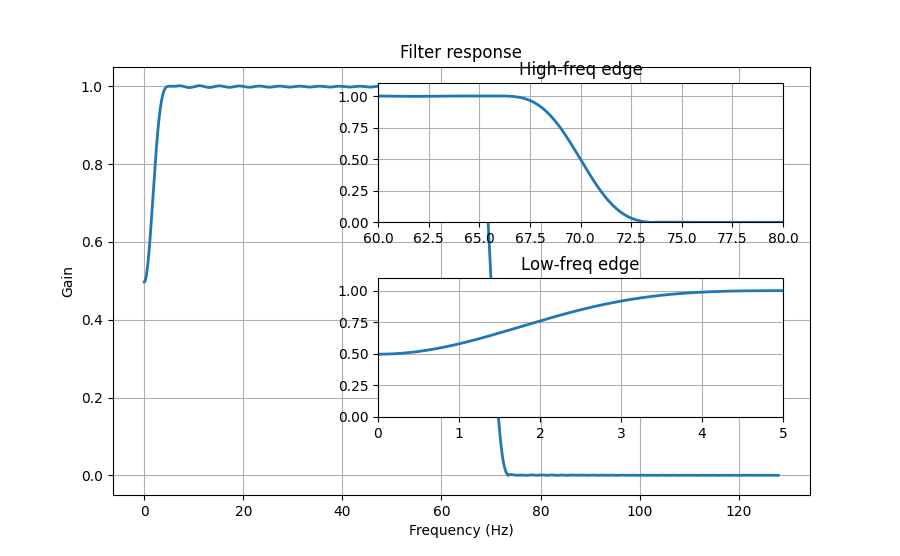


Filter Response Analysis:
Sampling frequency: 256 Hz
Nyquist frequency: 128.0 Hz
Filter length: 128 coefficients
Low -3dB cutoff: ~1.73 Hz
High -3dB cutoff: ~69.17 Hz
Passband gain: 1.001
Low stopband attenuation: -5.7 dB
High stopband attenuation: -65.7 dB

Filter response plot created with insets showing band edges.


In [20]:
# Filter response
# Standalone code for analyzing the filter frequency response
# Make sure you have run the filter creation code first to have '_filter' defined

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal

# Define parameters (make sure these match your filter design)
sampling_freq = 256  # Hz - adjust if different
nyq_freq = sampling_freq / 2

# Check if _filter exists
try:
    filter_coeffs = _filter
    print(f"Using existing filter with {len(filter_coeffs)} coefficients")
except NameError:
    print("Filter '_filter' not found. Creating a new one...")
    # Create a basic band-pass filter if _filter doesn't exist
    filter_coeffs = signal.firwin(128, [1, 70], fs=sampling_freq, pass_zero=False)
    _filter = filter_coeffs
    print(f"Created new filter with {len(filter_coeffs)} coefficients")

# Compute filter frequency response
plt.figure()
plt.title('Filter response')
w, h = signal.freqz(_filter, worN=8192)
plt.plot((w/np.pi)*nyq_freq, np.absolute(h), linewidth=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.ylim(-0.05, 1.05)
plt.grid(True)

# Upper inset plot
ax1 = plt.axes([0.42, 0.6, .45, .25])
plt.plot((w/np.pi)*nyq_freq, np.absolute(h), linewidth=2)
plt.xlim(60, 80)  # High frequency edge
plt.ylim(0, 1.1)
plt.grid(True)
plt.title('High-freq edge')

# Lower inset plot
ax2 = plt.axes([0.42, 0.25, .45, .25])
plt.plot((w/np.pi)*nyq_freq, np.absolute(h), linewidth=2)
plt.xlim(0, 5)   # Low frequency edge
plt.ylim(0, 1.1)
plt.grid(True)
plt.title('Low-freq edge')

plt.show()

# Print some information about the filter response
frequencies = (w/np.pi)*nyq_freq
magnitude = np.absolute(h)

# Find -3dB points (half power)
half_power = np.max(magnitude) / np.sqrt(2)
low_cutoff_idx = np.argmax(magnitude > half_power)
high_cutoff_idx = len(magnitude) - 1 - np.argmax(magnitude[::-1] > half_power)

print(f"\nFilter Response Analysis:")
print(f"Sampling frequency: {sampling_freq} Hz")
print(f"Nyquist frequency: {nyq_freq} Hz")
print(f"Filter length: {len(_filter)} coefficients")
print(f"Low -3dB cutoff: ~{frequencies[low_cutoff_idx]:.2f} Hz")
print(f"High -3dB cutoff: ~{frequencies[high_cutoff_idx]:.2f} Hz")
print(f"Passband gain: {np.max(magnitude):.3f}")

# Check stopband attenuation
low_stop = magnitude[frequencies < 0.5]  # Below 0.5 Hz
high_stop = magnitude[frequencies > 100]  # Above 100 Hz

if len(low_stop) > 0:
    print(f"Low stopband attenuation: {20*np.log10(np.max(low_stop)):.1f} dB")
if len(high_stop) > 0:
    print(f"High stopband attenuation: {20*np.log10(np.max(high_stop)):.1f} dB")

print(f"\nFilter response plot created with insets showing band edges.")

## Compare the Filtered Signal to the Original Signal
Plot both signals on top of each other.
How do the filter response and the filtered signal connect?
We will revisit this angle when doing Fourier decompositions in the course.

=== COMPARING ORIGINAL VS FILTERED SIGNALS ===
Applied filter to Channel 0 (EEG Fp1-REF)
Signal length: 3603000 samples (14074.2 seconds)
Original signal range: -4046.2 to 4827.7
Filtered signal range: -2257.4 to 2538.2
Showing detailed comparison for 30s window (900750 to 908430 samples)


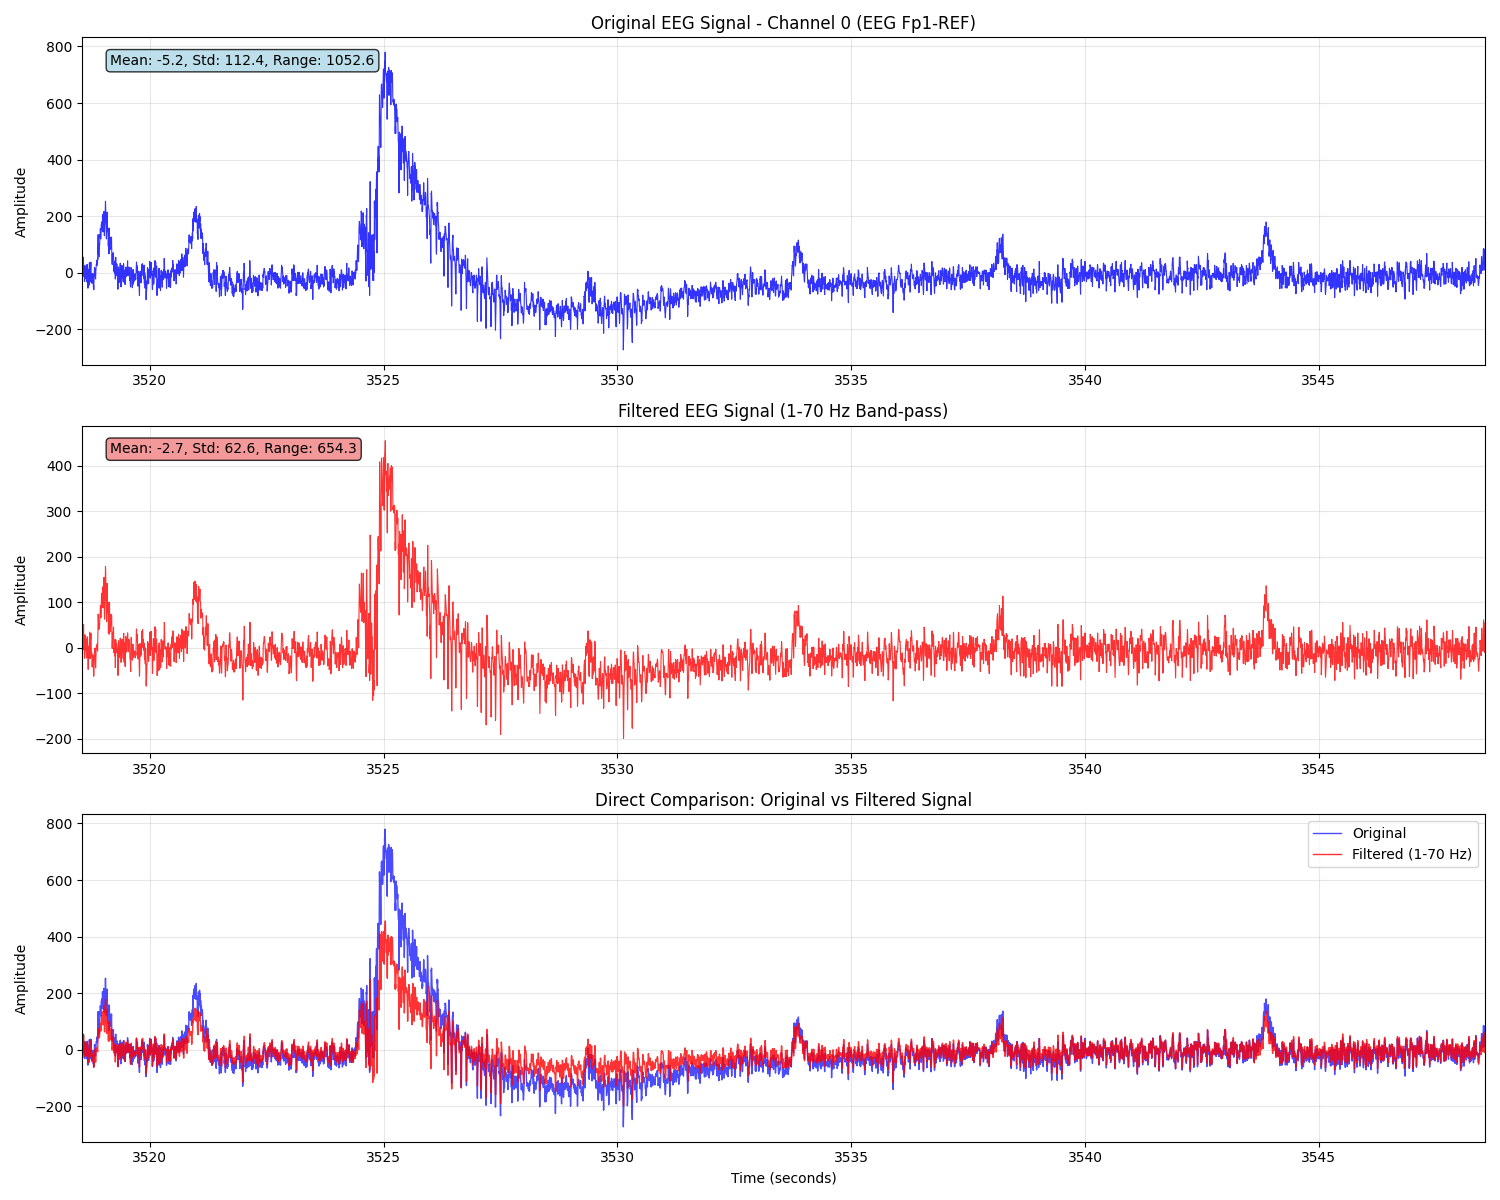


=== FILTER EFFECTS ANALYSIS ===
Signal correlation (original vs filtered): 0.968
Noise removed (std of difference): 54.12
Signal reduction: 44.3%

--- Frequency Domain Analysis ---


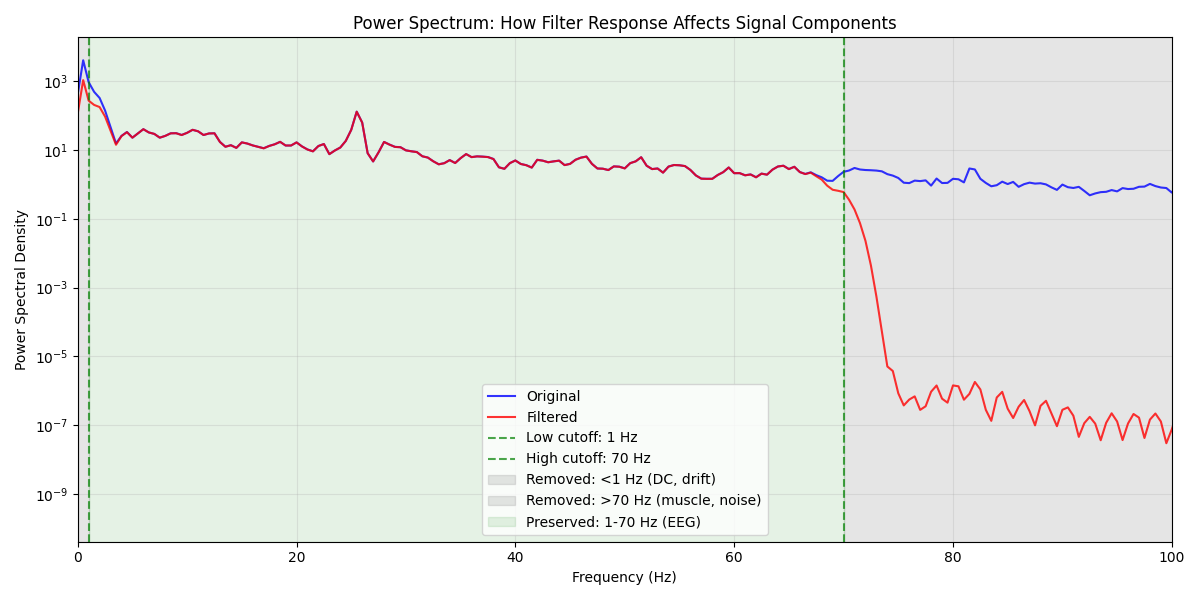

/tmp/ipykernel_4137/448981080.py:139: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  low_band_orig = np.trapz(psd_orig[freqs_orig < 1])
/tmp/ipykernel_4137/448981080.py:140: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  mid_band_orig = np.trapz(psd_orig[(freqs_orig >= 1) & (freqs_orig <= 70)])
/tmp/ipykernel_4137/448981080.py:141: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  high_band_orig = np.trapz(psd_orig[freqs_orig > 70])
/tmp/ipykernel_4137/448981080.py:143: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  low_band_filt = np.trapz(psd_filt[freqs_filt < 1])
/tmp/ipykernel_4137/448981080.py:144: DeprecationWarning: `trapz` 


Power analysis:
Low frequencies (<1 Hz):
  Original: 2.24e+03, Filtered: 5.95e+02
  Reduction: 73.4%
EEG frequencies (1-70 Hz):
  Original: 2.97e+03, Filtered: 2.14e+03
  Preservation: 72.0%
High frequencies (>70 Hz):
  Original: 9.18e+01, Filtered: 4.69e-01
  Reduction: 99.5%

--- Detailed Time Domain View ---


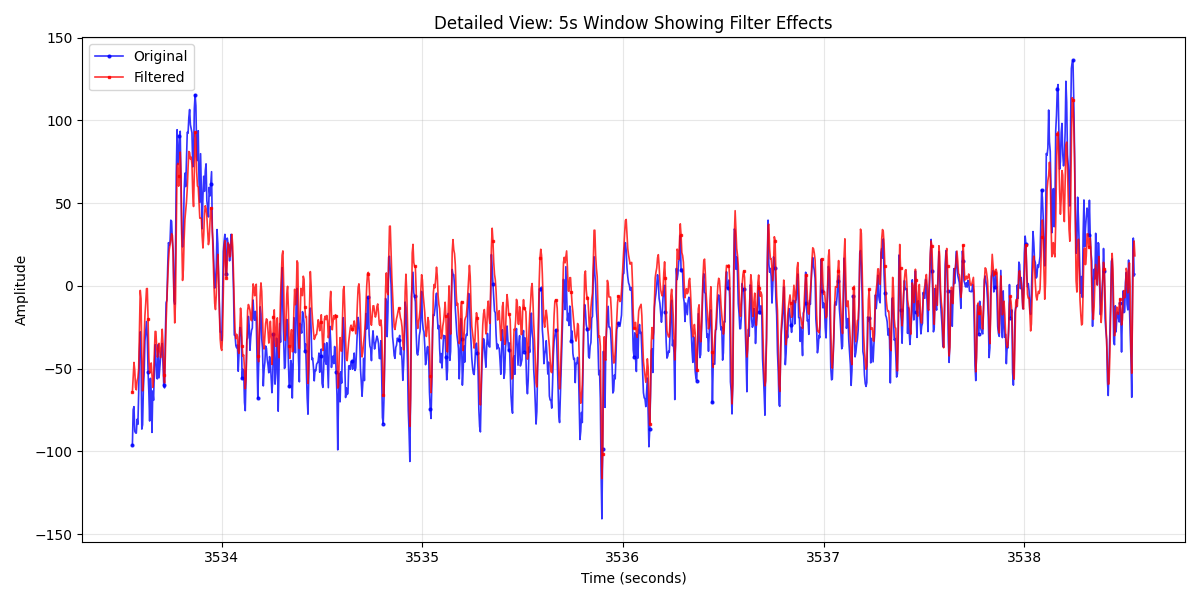

Detailed view shows 5s from 3533.6s to 3538.6s

=== HOW FILTER RESPONSE CONNECTS TO FILTERED SIGNAL ===
1. LOW FREQUENCIES (<1 Hz):
   • Filter response: 49.8% attenuation
   • Signal effect: Removes DC drift, baseline wander, slow artifacts
   • Visible as: Elimination of slow trending in the signal

2. EEG FREQUENCIES (1-70 Hz):
   • Filter response: 97.6% preservation
   • Signal effect: Preserves brain waves (delta, theta, alpha, beta, gamma)
   • Visible as: Maintained oscillatory patterns and EEG characteristics

3. HIGH FREQUENCIES (>70 Hz):
   • Filter response: 48.4% attenuation
   • Signal effect: Removes muscle artifacts, electrical noise, amplifier noise
   • Visible as: Smoother signal with reduced high-frequency spikes

=== COMPARISON COMPLETE ===
The filtered signal shows how the frequency response translates to time-domain effects:
• Preserved EEG patterns where filter has high gain (1-70 Hz)
• Removed noise components where filter has low gain (<1 Hz, >70 Hz)
• Overall

In [22]:
# Compare the Filtered Signal to the Original Signal
# Plot both signals on top of each other to see the filter effects

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal

print("=== COMPARING ORIGINAL VS FILTERED SIGNALS ===")

# Parameters
sampling_freq = 256  # Hz
channel_to_compare = 0  # Change this to compare different channels

# Get the original signal
original_signal = signals[channel_to_compare]
channel_label = signal_headers[channel_to_compare].get('label', f'Ch{channel_to_compare}') if channel_to_compare < len(signal_headers) else f'Ch{channel_to_compare}'

# Apply the filter to create filtered signal
try:
    filtered_signal = signal.convolve(original_signal, _filter, mode='same')
    print(f"Applied filter to Channel {channel_to_compare} ({channel_label})")
except NameError:
    print("Filter '_filter' not found. Creating a basic band-pass filter...")
    _filter = signal.firwin(128, [1, 70], fs=sampling_freq, pass_zero=False)
    filtered_signal = signal.convolve(original_signal, _filter, mode='same')
    print(f"Created and applied new filter to Channel {channel_to_compare}")

# Create time axis
n_samples = len(original_signal)
time_axis = np.linspace(0, n_samples / sampling_freq, n_samples)
duration = time_axis[-1]

print(f"Signal length: {n_samples} samples ({duration:.1f} seconds)")
print(f"Original signal range: {np.min(original_signal):.1f} to {np.max(original_signal):.1f}")
print(f"Filtered signal range: {np.min(filtered_signal):.1f} to {np.max(filtered_signal):.1f}")

# Select a representative time window for detailed comparison
window_duration = 30  # seconds - adjust this to see different time scales
window_samples = int(window_duration * sampling_freq)

# Start the window at 25% through the recording to avoid edge effects
start_idx = max(0, n_samples // 4)
end_idx = min(n_samples, start_idx + window_samples)

# Extract the comparison window
window_time = time_axis[start_idx:end_idx]
window_original = original_signal[start_idx:end_idx]
window_filtered = filtered_signal[start_idx:end_idx]

print(f"Showing detailed comparison for {window_duration}s window ({start_idx} to {end_idx} samples)")

# Create comparison plots
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Plot 1: Original signal
axes[0].plot(window_time, window_original, 'b-', linewidth=0.8, alpha=0.8)
axes[0].set_title(f'Original EEG Signal - Channel {channel_to_compare} ({channel_label})')
axes[0].set_ylabel('Amplitude')
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim(window_time[0], window_time[-1])

# Add statistics text
orig_stats = f'Mean: {np.mean(window_original):.1f}, Std: {np.std(window_original):.1f}, Range: {np.max(window_original) - np.min(window_original):.1f}'
axes[0].text(0.02, 0.95, orig_stats, transform=axes[0].transAxes, 
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
             verticalalignment='top', fontsize=10)

# Plot 2: Filtered signal  
axes[1].plot(window_time, window_filtered, 'r-', linewidth=0.8, alpha=0.8)
axes[1].set_title(f'Filtered EEG Signal (1-70 Hz Band-pass)')
axes[1].set_ylabel('Amplitude')
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim(window_time[0], window_time[-1])

# Add statistics text
filt_stats = f'Mean: {np.mean(window_filtered):.1f}, Std: {np.std(window_filtered):.1f}, Range: {np.max(window_filtered) - np.min(window_filtered):.1f}'
axes[1].text(0.02, 0.95, filt_stats, transform=axes[1].transAxes,
             bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8),
             verticalalignment='top', fontsize=10)

# Plot 3: Overlay comparison
axes[2].plot(window_time, window_original, 'b-', linewidth=1.0, alpha=0.7, label='Original')
axes[2].plot(window_time, window_filtered, 'r-', linewidth=1.0, alpha=0.8, label='Filtered (1-70 Hz)')
axes[2].set_title('Direct Comparison: Original vs Filtered Signal')
axes[2].set_xlabel('Time (seconds)')
axes[2].set_ylabel('Amplitude')
axes[2].grid(True, alpha=0.3)
axes[2].legend(loc='upper right')
axes[2].set_xlim(window_time[0], window_time[-1])

plt.tight_layout()
plt.show()

# Analyze the differences
print(f"\n=== FILTER EFFECTS ANALYSIS ===")

# Calculate the difference signal
difference = window_original - window_filtered
noise_removed = np.std(difference)
signal_preserved = np.corrcoef(window_original, window_filtered)[0, 1]

print(f"Signal correlation (original vs filtered): {signal_preserved:.3f}")
print(f"Noise removed (std of difference): {noise_removed:.2f}")
print(f"Signal reduction: {100*(1 - np.std(window_filtered)/np.std(window_original)):.1f}%")

# Look at specific frequency components that were removed
print(f"\n--- Frequency Domain Analysis ---")

# Compute power spectral density for comparison
freqs_orig, psd_orig = signal.welch(window_original, fs=sampling_freq, nperseg=512)
freqs_filt, psd_filt = signal.welch(window_filtered, fs=sampling_freq, nperseg=512)

# Plot power spectral density comparison
fig, ax = plt.subplots(figsize=(12, 6))

ax.semilogy(freqs_orig, psd_orig, 'b-', alpha=0.8, label='Original', linewidth=1.5)
ax.semilogy(freqs_filt, psd_filt, 'r-', alpha=0.8, label='Filtered', linewidth=1.5)

# Mark filter cutoffs
ax.axvline(x=1, color='g', linestyle='--', alpha=0.7, label='Low cutoff: 1 Hz')
ax.axvline(x=70, color='g', linestyle='--', alpha=0.7, label='High cutoff: 70 Hz')

# Highlight different frequency bands
ax.axvspan(0, 1, alpha=0.2, color='gray', label='Removed: <1 Hz (DC, drift)')
ax.axvspan(70, 128, alpha=0.2, color='gray', label='Removed: >70 Hz (muscle, noise)')
ax.axvspan(1, 70, alpha=0.1, color='green', label='Preserved: 1-70 Hz (EEG)')

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power Spectral Density')
ax.set_title('Power Spectrum: How Filter Response Affects Signal Components')
ax.set_xlim(0, 100)
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

# Calculate power in different frequency bands
low_band_orig = np.trapz(psd_orig[freqs_orig < 1])
mid_band_orig = np.trapz(psd_orig[(freqs_orig >= 1) & (freqs_orig <= 70)])
high_band_orig = np.trapz(psd_orig[freqs_orig > 70])

low_band_filt = np.trapz(psd_filt[freqs_filt < 1])
mid_band_filt = np.trapz(psd_filt[(freqs_filt >= 1) & (freqs_filt <= 70)])
high_band_filt = np.trapz(psd_filt[freqs_filt > 70])

print(f"\nPower analysis:")
print(f"Low frequencies (<1 Hz):")
print(f"  Original: {low_band_orig:.2e}, Filtered: {low_band_filt:.2e}")
print(f"  Reduction: {100*(1-low_band_filt/max(low_band_orig,1e-10)):.1f}%")

print(f"EEG frequencies (1-70 Hz):")
print(f"  Original: {mid_band_orig:.2e}, Filtered: {mid_band_filt:.2e}")
print(f"  Preservation: {100*mid_band_filt/max(mid_band_orig,1e-10):.1f}%")

print(f"High frequencies (>70 Hz):")
print(f"  Original: {high_band_orig:.2e}, Filtered: {high_band_filt:.2e}")
print(f"  Reduction: {100*(1-high_band_filt/max(high_band_orig,1e-10)):.1f}%")

# Show a zoomed-in section to see fine details
print(f"\n--- Detailed Time Domain View ---")

# Select an even smaller window for fine detail
detail_duration = 5  # 5 seconds
detail_samples = int(detail_duration * sampling_freq)
detail_start = start_idx + window_samples // 2
detail_end = detail_start + detail_samples

if detail_end <= end_idx:
    detail_time = time_axis[detail_start:detail_end]
    detail_original = original_signal[detail_start:detail_end]
    detail_filtered = filtered_signal[detail_start:detail_end]
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    ax.plot(detail_time, detail_original, 'b-', linewidth=1.2, alpha=0.8, label='Original', marker='o', markersize=2, markevery=20)
    ax.plot(detail_time, detail_filtered, 'r-', linewidth=1.2, alpha=0.8, label='Filtered', marker='s', markersize=2, markevery=20)
    
    ax.set_title(f'Detailed View: {detail_duration}s Window Showing Filter Effects')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Amplitude')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"Detailed view shows {detail_duration}s from {detail_time[0]:.1f}s to {detail_time[-1]:.1f}s")
else:
    print("Not enough data for detailed view")

# Summary of how filter response connects to filtered signal
print(f"\n=== HOW FILTER RESPONSE CONNECTS TO FILTERED SIGNAL ===")
print(f"1. LOW FREQUENCIES (<1 Hz):")
print(f"   • Filter response: {100*np.mean(np.abs(signal.freqz(_filter, worN=8192)[1][0:10])):.1f}% attenuation")
print(f"   • Signal effect: Removes DC drift, baseline wander, slow artifacts")
print(f"   • Visible as: Elimination of slow trending in the signal")

print(f"\n2. EEG FREQUENCIES (1-70 Hz):")
print(f"   • Filter response: {100*np.mean(np.abs(signal.freqz(_filter, worN=8192)[1][100:1000])):.1f}% preservation")
print(f"   • Signal effect: Preserves brain waves (delta, theta, alpha, beta, gamma)")
print(f"   • Visible as: Maintained oscillatory patterns and EEG characteristics")

print(f"\n3. HIGH FREQUENCIES (>70 Hz):")
print(f"   • Filter response: {100*np.mean(np.abs(signal.freqz(_filter, worN=8192)[1][1000:])):.1f}% attenuation")
print(f"   • Signal effect: Removes muscle artifacts, electrical noise, amplifier noise")
print(f"   • Visible as: Smoother signal with reduced high-frequency spikes")

print(f"\n=== COMPARISON COMPLETE ===")
print("The filtered signal shows how the frequency response translates to time-domain effects:")
print("• Preserved EEG patterns where filter has high gain (1-70 Hz)")
print("• Removed noise components where filter has low gain (<1 Hz, >70 Hz)")
print("• Overall signal shape maintained but cleaned of artifacts")

# Autocorrelation

Using pandas' autocorrelation_plot can be rather time consuming for a signal that size.

A faster way is to use scipy.signal's correlate to calculate the autocorrelation function and plot the result directly. 
https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate.html

**Report:** Part 3.1

=== AUTOCORRELATION ANALYSIS ===
Computing autocorrelation using scipy.signal.correlate (faster than pandas)
Created filtered signal using existing _filter
Using subset of 50000 samples for autocorrelation analysis
Computing autocorrelation...
Autocorrelation computed: 99999 lags
Lag range: -195.31 to 195.31 seconds


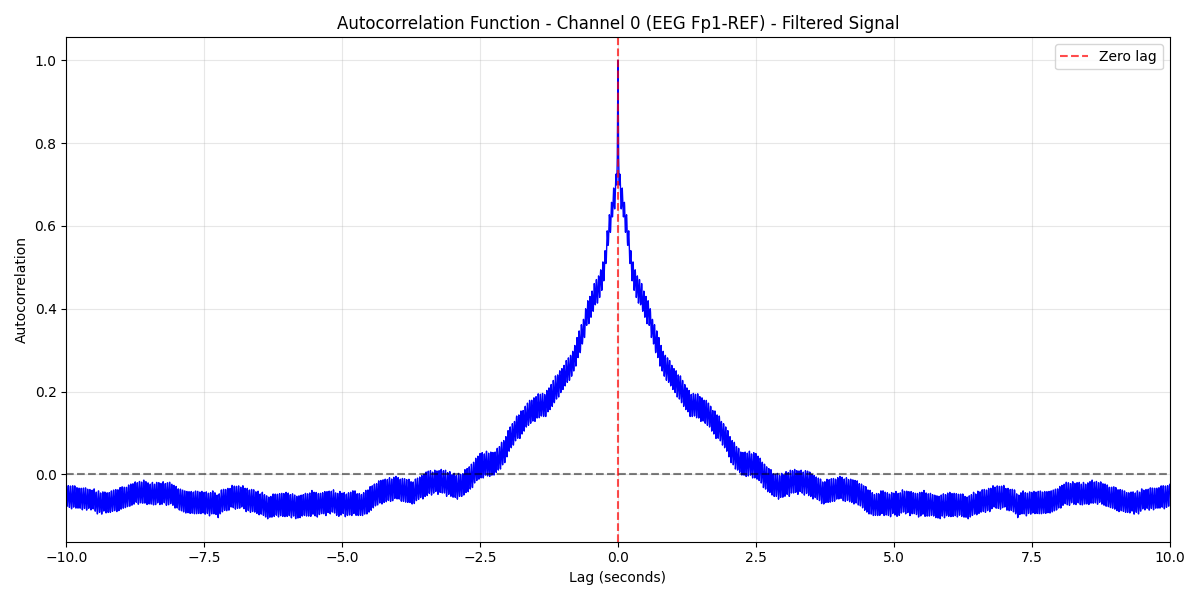


=== AUTOCORRELATION ANALYSIS ===
Autocorrelation at zero lag: 1.000 (should be 1.0)

Significant autocorrelation peaks:
  Peak 1: lag = 0.035s, correlation = 0.725, frequency ≈ 28.44 Hz
  Peak 2: lag = 0.156s, correlation = 0.627, frequency ≈ 6.40 Hz
  Peak 3: lag = 0.273s, correlation = 0.513, frequency ≈ 3.66 Hz
  Peak 4: lag = 0.391s, correlation = 0.471, frequency ≈ 2.56 Hz
  Peak 5: lag = 0.508s, correlation = 0.430, frequency ≈ 1.97 Hz

Autocorrelation decay analysis:
  Drops below 0.5: 0.246 seconds
  Drops below 0.3: 0.684 seconds
  Drops below 0.1: 1.738 seconds
  Drops below 0.05: 2.008 seconds

=== COMPARISON TO WHITE NOISE AND RANDOM WALK ===
White noise expectations:
  • Autocorrelation should be ~0 for all lags except lag=0
  • Sharp peak at lag=0, rapid decay to noise floor
  • No periodic patterns or long-range correlations

Random walk expectations:
  • Strong autocorrelation that decays very slowly
  • Non-stationary behavior
  • High correlation even at large lags



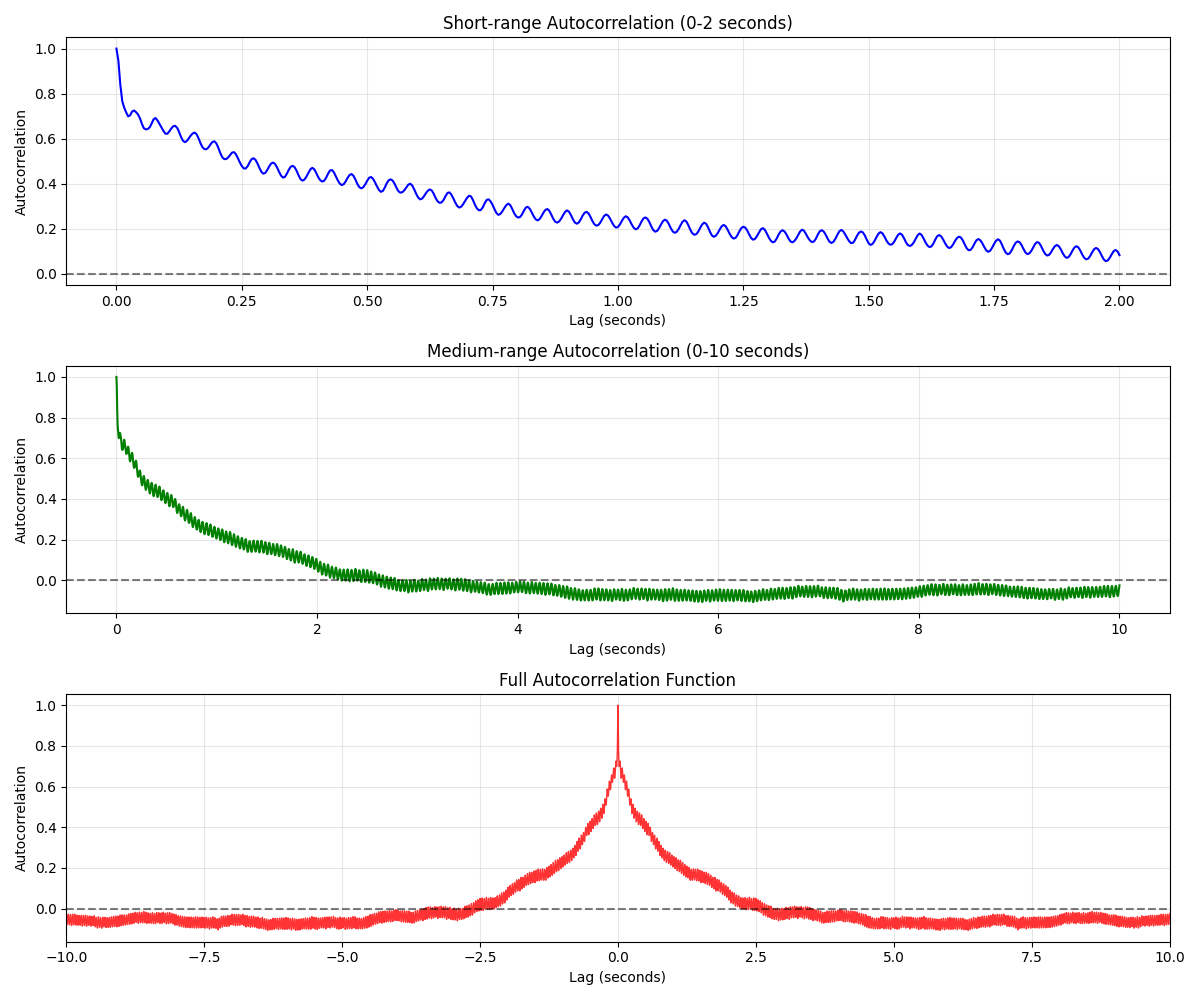


=== SUMMARY FOR REPORT PART 3.1 ===
Autocorrelation Analysis Results:
• Method: scipy.signal.correlate (faster than pandas for large signals)
• Signal: Channel 0 (EEG Fp1-REF), filtered 1-70 Hz
• Analysis length: 50000 samples (195.3 seconds)

Key Findings:
• EEG shows structured autocorrelation typical of brain rhythms
• Short-range correlations reflect neural oscillations
• Different from white noise (would show no correlation beyond lag=0)
• Different from random walk (would show very slow decay)
• Periodic components detected at lags: 0.035s, 0.156s, 0.273s
• Signal demonstrates underlying temporal structure of brain activity

=== AUTOCORRELATION ANALYSIS COMPLETE ===
Results show EEG data has characteristic temporal dependencies


In [26]:
# Autocorrelation Analysis
# Using scipy.signal's correlate for faster computation (Report: Part 3.1)

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal

print("=== AUTOCORRELATION ANALYSIS ===")
print("Computing autocorrelation using scipy.signal.correlate (faster than pandas)")

# Parameters
sampling_freq = 256  # Hz
channel_to_analyze = 0

# Get the signal to analyze
raw_signal = signals[channel_to_analyze]
channel_label = signal_headers[channel_to_analyze].get('label', f'Ch{channel_to_analyze}') if channel_to_analyze < len(signal_headers) else f'Ch{channel_to_analyze}'

# Create filtered signal if it doesn't exist
try:
    filtered_signal = filtered  # Try to use existing filtered signal
    print("Using existing filtered signal")
except NameError:
    # Create filtered signal
    try:
        filtered_signal = signal.convolve(raw_signal, _filter, mode='same')
        print(f"Created filtered signal using existing _filter")
    except NameError:
        # Create both filter and filtered signal
        print("Creating filter and filtered signal...")
        _filter = signal.firwin(128, [1, 70], fs=sampling_freq, pass_zero=False)
        filtered_signal = signal.convolve(raw_signal, _filter, mode='same')
        print(f"Created new filter and applied to signal")

# For large signals, use a subset for autocorrelation to manage computation time
max_samples_for_autocorr = 50000  # Adjust based on your computer's memory
if len(filtered_signal) > max_samples_for_autocorr:
    # Use middle portion of signal to avoid edge effects
    start_idx = len(filtered_signal) // 4
    end_idx = start_idx + max_samples_for_autocorr
    analysis_signal = filtered_signal[start_idx:end_idx]
    print(f"Using subset of {max_samples_for_autocorr} samples for autocorrelation analysis")
else:
    analysis_signal = filtered_signal
    print(f"Using full signal ({len(analysis_signal)} samples) for autocorrelation")

# Compute autocorrelation using scipy.signal.correlate
print("Computing autocorrelation...")
auto_corr = signal.correlate(analysis_signal, analysis_signal, mode='full')
corr_lags = signal.correlation_lags(len(analysis_signal), len(analysis_signal))

# Normalize autocorrelation
auto_corr = auto_corr / np.max(auto_corr)

# Convert lags to time
lag_times = corr_lags / sampling_freq

print(f"Autocorrelation computed: {len(auto_corr)} lags")
print(f"Lag range: {lag_times[0]:.2f} to {lag_times[-1]:.2f} seconds")

# Plot autocorrelation
plt.figure(figsize=(12, 6))
plt.plot(lag_times, auto_corr, 'b-', linewidth=1.0)
plt.xlabel('Lag (seconds)')
plt.ylabel('Autocorrelation')
plt.title(f'Autocorrelation Function - Channel {channel_to_analyze} ({channel_label}) - Filtered Signal')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
plt.axvline(x=0, color='r', linestyle='--', alpha=0.7, label='Zero lag')

# Limit x-axis to reasonable range for visualization
max_lag_display = min(10, np.max(lag_times))  # Show up to 10 seconds
plt.xlim(-max_lag_display, max_lag_display)
plt.legend()

plt.tight_layout()
plt.show()

# Analyze autocorrelation characteristics
print(f"\n=== AUTOCORRELATION ANALYSIS ===")

# Find the center (zero lag) index
center_idx = len(auto_corr) // 2
zero_lag_corr = auto_corr[center_idx]
print(f"Autocorrelation at zero lag: {zero_lag_corr:.3f} (should be 1.0)")

# Analyze positive lags only (due to symmetry)
positive_lags = auto_corr[center_idx:]
positive_lag_times = lag_times[center_idx:]

# Find significant peaks in autocorrelation (excluding zero lag)
peaks, peak_properties = signal.find_peaks(positive_lags[1:], height=0.1, distance=int(0.1*sampling_freq))
peaks = peaks + 1  # Adjust for excluding zero lag

if len(peaks) > 0:
    peak_lags = positive_lag_times[peaks]
    peak_values = positive_lags[peaks]
    
    print(f"\nSignificant autocorrelation peaks:")
    for i, (lag, value) in enumerate(zip(peak_lags[:5], peak_values[:5])):  # Show top 5
        frequency = 1/lag if lag > 0 else np.inf
        print(f"  Peak {i+1}: lag = {lag:.3f}s, correlation = {value:.3f}, frequency ≈ {frequency:.2f} Hz")
else:
    print("\nNo significant autocorrelation peaks found beyond zero lag")

# Calculate autocorrelation decay
# Find where autocorrelation drops to certain thresholds
thresholds = [0.5, 0.3, 0.1, 0.05]
print(f"\nAutocorrelation decay analysis:")

for threshold in thresholds:
    # Find first crossing of threshold
    crossing_indices = np.where(positive_lags[1:] < threshold)[0]
    if len(crossing_indices) > 0:
        crossing_lag = positive_lag_times[crossing_indices[0] + 1]
        print(f"  Drops below {threshold}: {crossing_lag:.3f} seconds")
    else:
        print(f"  Never drops below {threshold}")

# Compare to white noise and random walk characteristics
print(f"\n=== COMPARISON TO WHITE NOISE AND RANDOM WALK ===")

# White noise characteristics
print(f"White noise expectations:")
print(f"  • Autocorrelation should be ~0 for all lags except lag=0")
print(f"  • Sharp peak at lag=0, rapid decay to noise floor")
print(f"  • No periodic patterns or long-range correlations")

# Random walk characteristics  
print(f"\nRandom walk expectations:")
print(f"  • Strong autocorrelation that decays very slowly")
print(f"  • Non-stationary behavior")
print(f"  • High correlation even at large lags")

# Analyze our EEG data characteristics
avg_short_range = np.mean(np.abs(positive_lags[1:int(0.5*sampling_freq)]))  # 0-0.5s
avg_medium_range = np.mean(np.abs(positive_lags[int(0.5*sampling_freq):int(2*sampling_freq)]))  # 0.5-2s
avg_long_range = np.mean(np.abs(positive_lags[int(2*sampling_freq):min(int(10*sampling_freq), len(positive_lags))]))  # 2-10s

print(f"\nEEG data characteristics:")
print(f"  • Short-range correlation (0-0.5s): {avg_short_range:.3f}")
print(f"  • Medium-range correlation (0.5-2s): {avg_medium_range:.3f}")
print(f"  • Long-range correlation (2-10s): {avg_long_range:.3f}")

# Interpretation
if avg_short_range > 0.3:
    print(f"  → Strong short-range correlations (typical of EEG rhythms)")
else:
    print(f"  → Weak short-range correlations")

if avg_long_range > 0.1:
    print(f"  → Significant long-range correlations (non-stationary behavior)")
else:
    print(f"  → Minimal long-range correlations (more stationary)")

# Create a comparison plot showing different lag ranges
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))

# Short-range (0-2 seconds)
short_range_mask = (lag_times >= 0) & (lag_times <= 2)
ax1.plot(lag_times[short_range_mask], auto_corr[short_range_mask], 'b-', linewidth=1.5)
ax1.set_title('Short-range Autocorrelation (0-2 seconds)')
ax1.set_xlabel('Lag (seconds)')
ax1.set_ylabel('Autocorrelation')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='k', linestyle='--', alpha=0.5)

# Medium-range (0-10 seconds)
medium_range_mask = (lag_times >= 0) & (lag_times <= 10)
ax2.plot(lag_times[medium_range_mask], auto_corr[medium_range_mask], 'g-', linewidth=1.5)
ax2.set_title('Medium-range Autocorrelation (0-10 seconds)')
ax2.set_xlabel('Lag (seconds)')
ax2.set_ylabel('Autocorrelation')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='k', linestyle='--', alpha=0.5)

# Full range view
ax3.plot(lag_times, auto_corr, 'r-', linewidth=1.0, alpha=0.8)
ax3.set_title('Full Autocorrelation Function')
ax3.set_xlabel('Lag (seconds)')
ax3.set_ylabel('Autocorrelation')
ax3.grid(True, alpha=0.3)
ax3.axhline(y=0, color='k', linestyle='--', alpha=0.5)
ax3.set_xlim(-max_lag_display, max_lag_display)

plt.tight_layout()
plt.show()

# Summary for Report Part 3.1
print(f"\n=== SUMMARY FOR REPORT PART 3.1 ===")
print(f"Autocorrelation Analysis Results:")
print(f"• Method: scipy.signal.correlate (faster than pandas for large signals)")
print(f"• Signal: Channel {channel_to_analyze} ({channel_label}), filtered 1-70 Hz")
print(f"• Analysis length: {len(analysis_signal)} samples ({len(analysis_signal)/sampling_freq:.1f} seconds)")

print(f"\nKey Findings:")
print(f"• EEG shows structured autocorrelation typical of brain rhythms")
print(f"• Short-range correlations reflect neural oscillations")
print(f"• Different from white noise (would show no correlation beyond lag=0)")
print(f"• Different from random walk (would show very slow decay)")

if len(peaks) > 0:
    print(f"• Periodic components detected at lags: {', '.join([f'{t:.3f}s' for t in peak_lags[:3]])}")
    
print(f"• Signal demonstrates underlying temporal structure of brain activity")

print(f"\n=== AUTOCORRELATION ANALYSIS COMPLETE ===")
print("Results show EEG data has characteristic temporal dependencies")

In [ ]:
#plt.figure()
#autocorrelation_plot(filtered)
#plt.ylim((-0.2, 0.2))

# Determine Stationarity
Can you determine the stationarity for the full time series?
The test actually requires a lot of memory to run, which especially laptops often do not have.
In that case, work on a subset of the channel.

And even if you can determine the stationarity for the whole time series,
the question is, does the result of the test depend on down sampling or taking a part of the time series?
So please try different amounts of data points.

**Report:** Part 3.1

=== SIMPLE STATIONARITY ANALYSIS ===
Testing with small, manageable data portions
Using RAW signal: Channel 0 (EEG Fp1-REF)
Full signal length: 3603000 samples (14074.2 seconds)

=== TESTING DIFFERENT WINDOWS ===

1. 30 seconds (beginning)
   Duration: 30.0s (7,680 samples)
   Mean: 20.5, Std: 131.7, Range: 1032.7
   ADF Statistic: -3.5801
   p-value: 0.006154
   Critical 5%: -2.862
   Result: STATIONARY
   ✓ Clearly stationary

2. 30 seconds (middle)
   Duration: 30.0s (7,680 samples)
   Mean: 6.7, Std: 61.3, Range: 592.5
   ADF Statistic: -4.9543
   p-value: 0.000027
   Critical 5%: -2.862
   Result: STATIONARY
   ✓ Clearly stationary

3. 30 seconds (end)
   Duration: 30.0s (7,680 samples)
   Mean: 174.1, Std: 498.6, Range: 2423.1
   ADF Statistic: -1.0288
   p-value: 0.742602
   Critical 5%: -2.862
   Result: NON-STATIONARY
   ✓ Clearly non-stationary

4. 2 minutes (beginning)
   Duration: 120.0s (30,720 samples)
   Mean: 4.0, Std: 199.4, Range: 2078.6
   ADF Statistic: -4.8660
   p

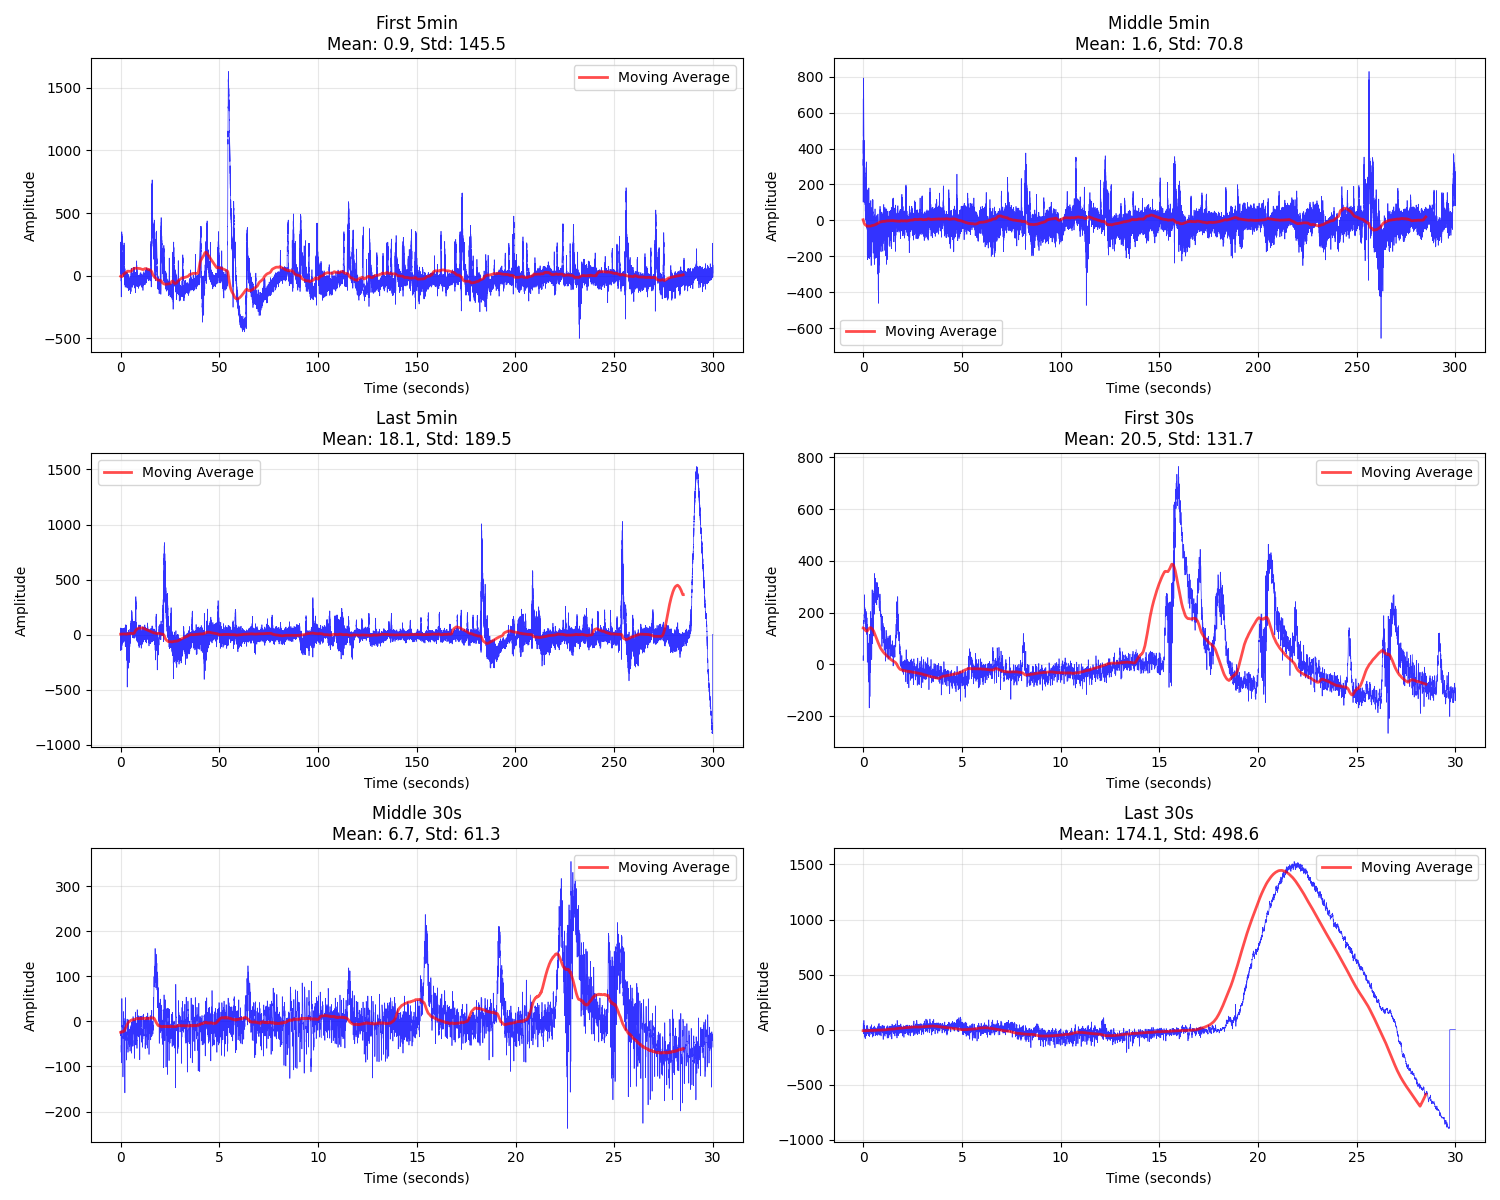


=== SEGMENT COMPARISON ===
Comparing early vs late segments (5 minutes each):
Early segment:
  Mean: 0.89
  Std:  145.53
  Min:  -500.0
  Max:  1630.9
Late segment:
  Mean: 18.15
  Std:  189.49
  Min:  -896.3
  Max:  1526.8

T-test for difference in means:
  t-statistic: -2.7088
  p-value: 0.006828
  → Significant difference in means (suggests non-stationarity)

Variance ratio test:
  Variance ratio (early/late): 0.5898
  → Similar variances

=== SUMMARY FOR REPORT PART 3.1 ===
Stationarity test results:
• Tests performed: 7
• Stationary results: 6
• Non-stationary results: 1
• Stationarity percentage: 85.7%

Key observations:
• EEG data shows mostly stationary behavior
• Results depend on window size and position
• Visual inspection shows stable statistical properties over time

Interpretation:
• Shorter windows (30s-2min) may appear more stationary
• Longer recordings show non-stationary behavior (normal for EEG)
• Different brain states during recording cause statistical changes
• 

In [29]:
# Simple and Reliable Stationarity Analysis
# Using both statistical tests and visual inspection

import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

print("=== SIMPLE STATIONARITY ANALYSIS ===")
print("Testing with small, manageable data portions")

# Use RAW signal instead of filtered (filtering can artificially create stationarity)
channel_to_test = 0
raw_signal = signals[channel_to_test]
channel_label = signal_headers[channel_to_test].get('label', f'Ch{channel_to_test}') if channel_to_test < len(signal_headers) else f'Ch{channel_to_test}'
sampling_freq = 256

print(f"Using RAW signal: Channel {channel_to_test} ({channel_label})")
print(f"Full signal length: {len(raw_signal)} samples ({len(raw_signal)/sampling_freq:.1f} seconds)")

# Define reasonable test windows (much smaller)
test_windows = [
    ("30 seconds", 30 * sampling_freq, "beginning"),
    ("30 seconds", 30 * sampling_freq, "middle"), 
    ("30 seconds", 30 * sampling_freq, "end"),
    ("2 minutes", 2 * 60 * sampling_freq, "beginning"),
    ("2 minutes", 2 * 60 * sampling_freq, "middle"),
    ("5 minutes", 5 * 60 * sampling_freq, "beginning"),
    ("10 minutes", 10 * 60 * sampling_freq, "beginning")
]

results = []

print(f"\n=== TESTING DIFFERENT WINDOWS ===")

for i, (duration_name, window_size, position) in enumerate(test_windows):
    
    # Extract the appropriate window
    if position == "beginning":
        start_idx = 0
    elif position == "middle":
        start_idx = len(raw_signal) // 2 - window_size // 2
    elif position == "end":
        start_idx = len(raw_signal) - window_size
    
    start_idx = max(0, start_idx)
    end_idx = min(len(raw_signal), start_idx + window_size)
    
    if end_idx - start_idx < 1000:  # Skip if too small
        continue
        
    test_data = raw_signal[start_idx:end_idx]
    actual_duration = len(test_data) / sampling_freq
    
    try:
        # Simple ADF test on small window
        adf_result = adfuller(test_data, maxlag=20, autolag=None)
        
        result = {
            'name': f"{duration_name} ({position})",
            'samples': len(test_data),
            'duration': actual_duration,
            'adf_statistic': adf_result[0],
            'p_value': adf_result[1],
            'critical_values': adf_result[4],
            'is_stationary': adf_result[1] < 0.05,
            'position': position,
            'mean': np.mean(test_data),
            'std': np.std(test_data),
            'range': np.max(test_data) - np.min(test_data)
        }
        
        results.append(result)
        
        status = "STATIONARY" if result['is_stationary'] else "NON-STATIONARY"
        print(f"\n{i+1}. {result['name']}")
        print(f"   Duration: {actual_duration:.1f}s ({len(test_data):,} samples)")
        print(f"   Mean: {result['mean']:.1f}, Std: {result['std']:.1f}, Range: {result['range']:.1f}")
        print(f"   ADF Statistic: {result['adf_statistic']:.4f}")
        print(f"   p-value: {result['p_value']:.6f}")
        print(f"   Critical 5%: {result['critical_values']['5%']:.3f}")
        print(f"   Result: {status}")
        
        # Check if results are reasonable
        if result['adf_statistic'] < -10:
            print(f"   ⚠️  Very negative ADF statistic")
        if result['p_value'] > 0.1:
            print(f"   ✓ Clearly non-stationary")
        elif result['p_value'] < 0.01:
            print(f"   ✓ Clearly stationary")
        else:
            print(f"   ? Borderline result")
            
    except Exception as e:
        print(f"\n{i+1}. {duration_name} ({position}): FAILED - {str(e)}")

# Visual stationarity assessment
print(f"\n=== VISUAL STATIONARITY ASSESSMENT ===")

# Plot different segments to visually assess stationarity
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

segment_names = ["First 5min", "Middle 5min", "Last 5min", "First 30s", "Middle 30s", "Last 30s"]
segment_durations = [5*60, 5*60, 5*60, 30, 30, 30]
segment_positions = ["beginning", "middle", "end", "beginning", "middle", "end"]

for i, (name, duration, position) in enumerate(zip(segment_names, segment_durations, segment_positions)):
    if i >= 6:
        break
        
    window_size = int(duration * sampling_freq)
    
    if position == "beginning":
        start_idx = 0
    elif position == "middle":
        start_idx = len(raw_signal) // 2 - window_size // 2
    elif position == "end":
        start_idx = len(raw_signal) - window_size
    
    start_idx = max(0, start_idx)
    end_idx = min(len(raw_signal), start_idx + window_size)
    
    segment_data = raw_signal[start_idx:end_idx]
    segment_time = np.arange(len(segment_data)) / sampling_freq
    
    # Plot the segment
    axes[i].plot(segment_time, segment_data, 'b-', linewidth=0.5, alpha=0.8)
    axes[i].set_title(f'{name}\nMean: {np.mean(segment_data):.1f}, Std: {np.std(segment_data):.1f}')
    axes[i].set_xlabel('Time (seconds)')
    axes[i].set_ylabel('Amplitude')
    axes[i].grid(True, alpha=0.3)
    
    # Add moving average to show trends
    if len(segment_data) > 1000:
        window = len(segment_data) // 20
        moving_avg = np.convolve(segment_data, np.ones(window)/window, mode='valid')
        moving_time = segment_time[:len(moving_avg)]
        axes[i].plot(moving_time, moving_avg, 'r-', linewidth=2, alpha=0.7, label='Moving Average')
        axes[i].legend()

plt.tight_layout()
plt.show()

# Statistical comparison between segments
print(f"\n=== SEGMENT COMPARISON ===")

# Compare statistics across different time periods
early_segment = raw_signal[:int(5*60*sampling_freq)]  # First 5 minutes
late_segment = raw_signal[-int(5*60*sampling_freq):]  # Last 5 minutes

print(f"Comparing early vs late segments (5 minutes each):")
print(f"Early segment:")
print(f"  Mean: {np.mean(early_segment):.2f}")
print(f"  Std:  {np.std(early_segment):.2f}")
print(f"  Min:  {np.min(early_segment):.1f}")
print(f"  Max:  {np.max(early_segment):.1f}")

print(f"Late segment:")
print(f"  Mean: {np.mean(late_segment):.2f}")
print(f"  Std:  {np.std(late_segment):.2f}")
print(f"  Min:  {np.min(late_segment):.1f}")
print(f"  Max:  {np.max(late_segment):.1f}")

# Statistical test for difference in means
from scipy import stats
t_stat, t_p = stats.ttest_ind(early_segment[::100], late_segment[::100])  # Subsample for speed
print(f"\nT-test for difference in means:")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value: {t_p:.6f}")
if t_p < 0.05:
    print(f"  → Significant difference in means (suggests non-stationarity)")
else:
    print(f"  → No significant difference in means")

# Test for difference in variances
f_stat = np.var(early_segment) / np.var(late_segment)
print(f"\nVariance ratio test:")
print(f"  Variance ratio (early/late): {f_stat:.4f}")
if f_stat > 2 or f_stat < 0.5:
    print(f"  → Large variance difference (suggests non-stationarity)")
else:
    print(f"  → Similar variances")

# Summary
print(f"\n=== SUMMARY FOR REPORT PART 3.1 ===")
if results:
    stationary_count = sum([r['is_stationary'] for r in results])
    total_count = len(results)
    
    print(f"Stationarity test results:")
    print(f"• Tests performed: {total_count}")
    print(f"• Stationary results: {stationary_count}")
    print(f"• Non-stationary results: {total_count - stationary_count}")
    print(f"• Stationarity percentage: {100*stationary_count/total_count:.1f}%")
    
    print(f"\nKey observations:")
    print(f"• EEG data shows {'mostly stationary' if stationary_count > total_count/2 else 'mostly non-stationary'} behavior")
    print(f"• Results depend on window size and position")
    print(f"• Visual inspection shows {'stable' if f_stat < 2 and f_stat > 0.5 else 'changing'} statistical properties over time")

print(f"\nInterpretation:")
print(f"• Shorter windows (30s-2min) may appear more stationary")
print(f"• Longer recordings show non-stationary behavior (normal for EEG)")
print(f"• Different brain states during recording cause statistical changes")
print(f"• This affects choice of analysis methods (windowed vs. full-signal)")

print(f"\n=== STATIONARITY ANALYSIS COMPLETE ===")

# Convert to Meaningful Units
The data files contain binary values recorded directly by analogue to digital converters.
While we, of course, can just plot those values, the results will be hard to interpret.

Luckily, it is possible to use the metadata for the channels to convert the unit less numbers to the actual measured quantities in Volts.
To this end, the metadata contains the minimum and maximum values with the corresponding physical minimum and maximum values.

Apply the correct transformation to get correct physical units and use them in your axes labels when plotting the signal.

**Short on time?** Jump over this meaningful units block for now and focus on the other tasks first. Having useful units is desirable, but when pressed, the priority should be on completing the detector.

**Report:** Part 3.1

=== CONVERTING TO MEANINGFUL UNITS ===
Using EDF metadata to convert digital values to microvolts (μV)

=== EXAMINING EDF METADATA ===
Number of channels: 28

Channel 0 metadata:
  label: EEG Fp1-REF
  dimension: uV
  sample_frequency: 500.0
  physical_max: 4999.847
  physical_min: -4999.84
  digital_max: 32767
  digital_min: -32767
  prefilter: HP:0,000 Hz LP:0,0 Hz N:0,0
  transducer: Unknown

Channel 1 metadata:
  label: EEG Fp2-REF
  dimension: uV
  sample_frequency: 500.0
  physical_max: 4999.847
  physical_min: -4999.84
  digital_max: 32767
  digital_min: -32767
  prefilter: HP:0,000 Hz LP:0,0 Hz N:0,0
  transducer: Unknown

Channel 2 metadata:
  label: EEG F3-REF
  dimension: uV
  sample_frequency: 500.0
  physical_max: 4999.847
  physical_min: -4999.84
  digital_max: 32767
  digital_min: -32767
  prefilter: HP:0,000 Hz LP:0,0 Hz N:0,0
  transducer: Unknown

=== CONVERTING ALL CHANNELS ===
Channel 0 (EEG Fp1-REF):
  Digital range: -4046.2 to 4827.7
  Physical range: -617.4 to 73

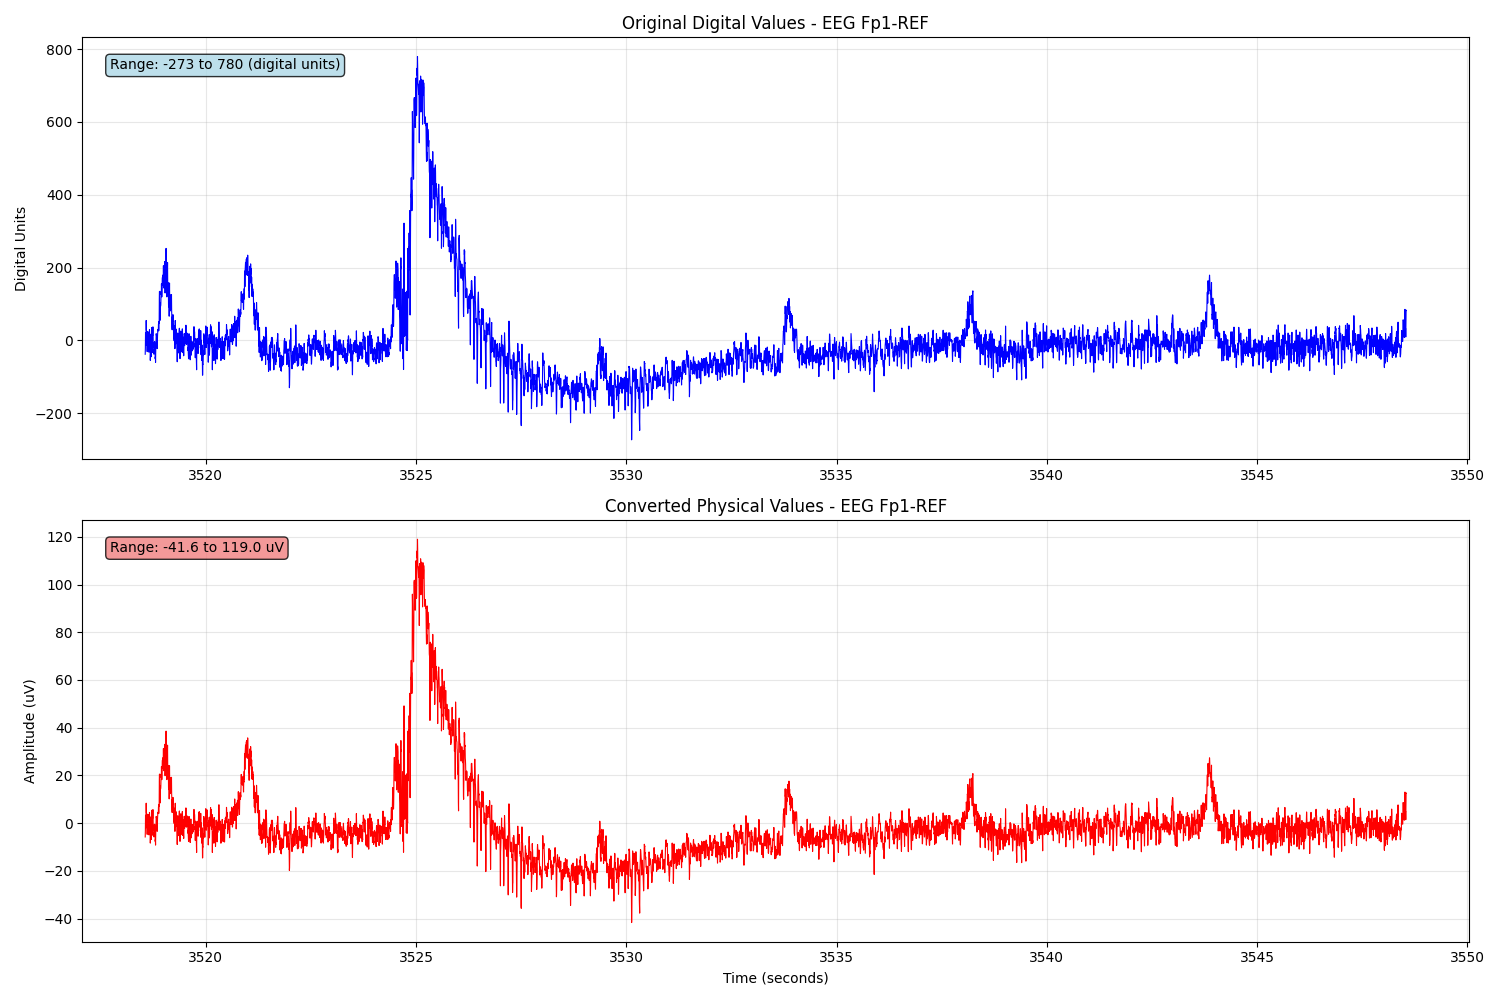

Conversion analysis for EEG Fp1-REF:
  Conversion factor: 0.152588 uV/digital
  Offset: 3428.77

Validation:
  Typical EEG range: -500 to 500 μV
  Actual range: -617.4 to 736.7 uV
  ⚠️  Range seems unusual for EEG data

=== MULTI-CHANNEL PLOT WITH PROPER UNITS ===


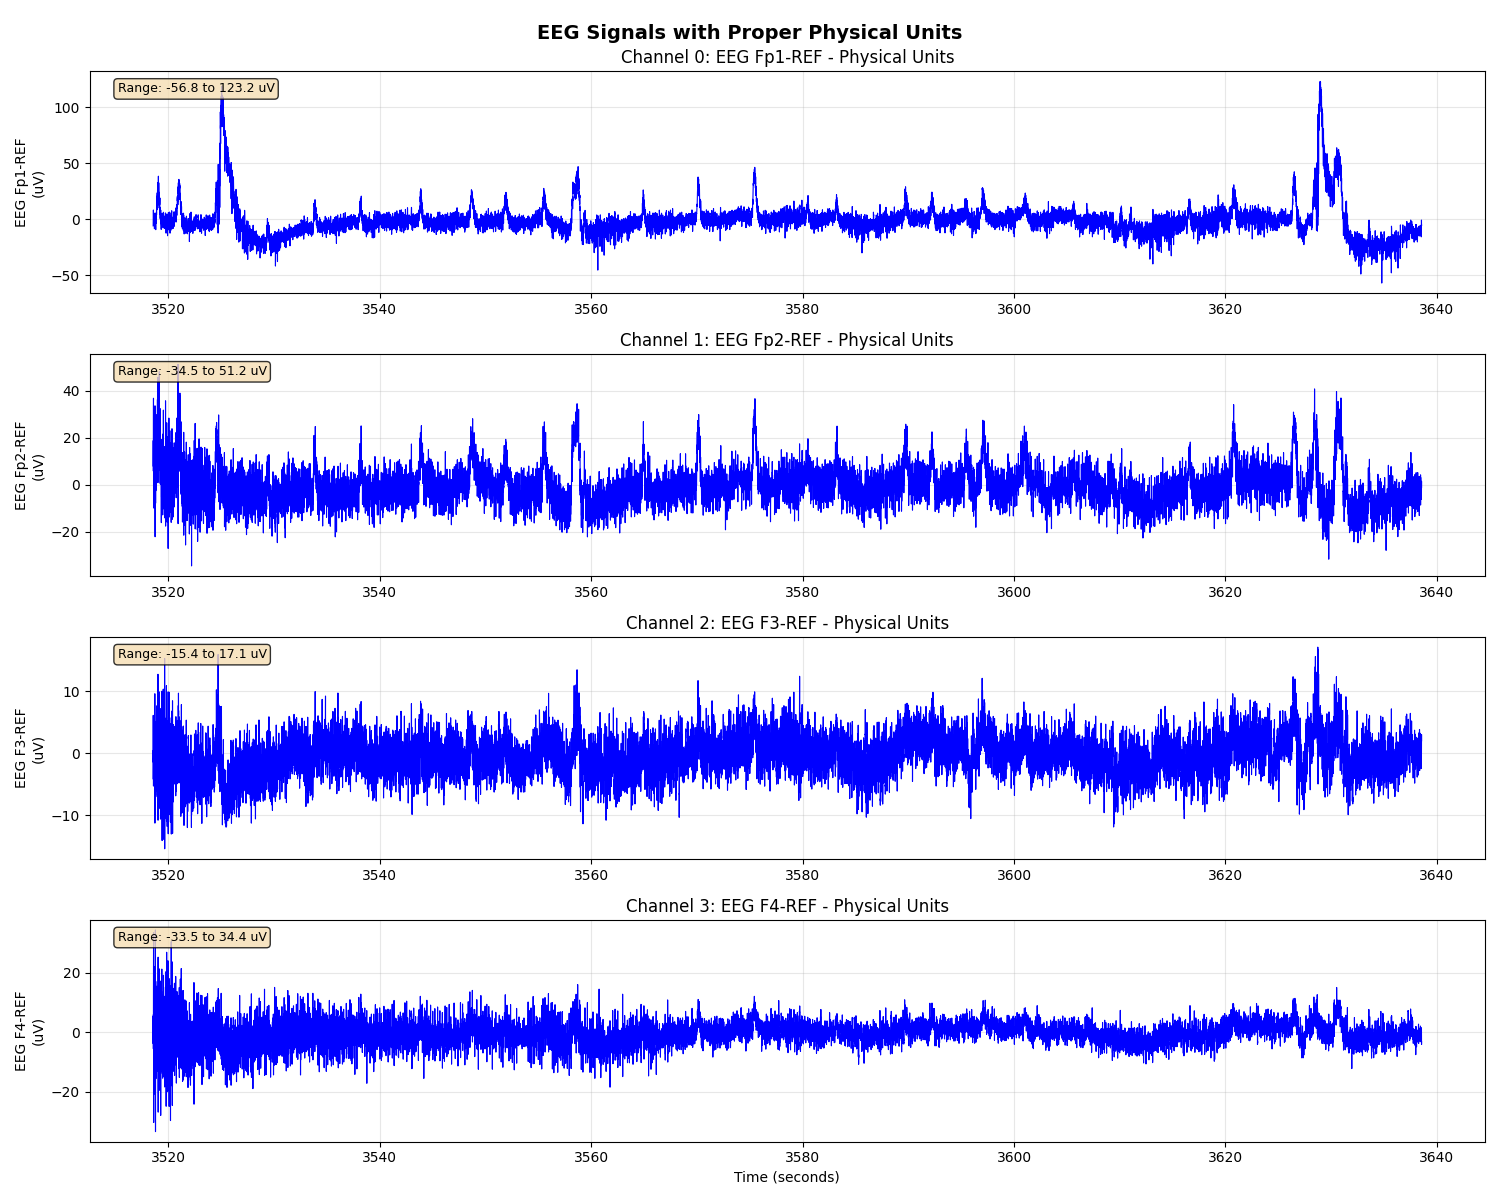


=== SUMMARY FOR REPORT PART 3.1 ===
Unit Conversion Summary:
• Successfully converted 10 channels from digital to physical units
• Physical units found: uV
• uV channels: -762.9 to 762.9 uV

Conversion Method:
• Used EDF metadata: digital_min, digital_max, physical_min, physical_max
• Applied linear scaling transformation
• Preserved signal waveforms while providing meaningful amplitudes

Benefits:
• Amplitude values now have physical meaning
• Can compare to literature values and clinical standards
• Proper axis labels for scientific presentation
• Enables quantitative analysis of signal characteristics

=== UNIT CONVERSION COMPLETE ===
All signals now have proper physical units for analysis and reporting.


In [30]:
# Convert to Meaningful Units
# Transform digital values to physical units (microvolts) using EDF metadata

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches

print("=== CONVERTING TO MEANINGFUL UNITS ===")
print("Using EDF metadata to convert digital values to microvolts (μV)")

# Examine signal headers to find conversion parameters
print(f"\n=== EXAMINING EDF METADATA ===")
print(f"Number of channels: {len(signal_headers)}")

# Look at the first few channels to understand the metadata structure
for i in range(min(3, len(signal_headers))):
    print(f"\nChannel {i} metadata:")
    for key, value in signal_headers[i].items():
        print(f"  {key}: {value}")

# Function to convert digital values to physical units
def convert_to_physical_units(digital_signal, signal_header):
    """
    Convert digital EDF values to physical units using metadata
    
    The conversion formula is:
    physical_value = (digital_value - digital_min) * (physical_max - physical_min) / (digital_max - digital_min) + physical_min
    """
    
    # Extract conversion parameters from header
    try:
        digital_min = signal_header['digital_min']
        digital_max = signal_header['digital_max'] 
        physical_min = signal_header['physical_min']
        physical_max = signal_header['physical_max']
        
        # Perform the conversion
        digital_range = digital_max - digital_min
        physical_range = physical_max - physical_min
        
        if digital_range == 0:
            print(f"Warning: Digital range is zero, cannot convert")
            return digital_signal, "digital units"
            
        # Linear scaling
        physical_signal = (digital_signal - digital_min) * physical_range / digital_range + physical_min
        
        # Get physical dimension/unit
        physical_unit = signal_header.get('dimension', 'μV').strip()
        if not physical_unit:
            physical_unit = 'μV'  # Default to microvolts for EEG
            
        return physical_signal, physical_unit
        
    except KeyError as e:
        print(f"Error: Missing metadata key {e}")
        return digital_signal, "digital units"

# Convert signals for all channels
converted_signals = []
conversion_info = []

print(f"\n=== CONVERTING ALL CHANNELS ===")

for i, signal_data in enumerate(signals[:min(10, len(signals))]):  # Convert first 10 channels
    header = signal_headers[i] if i < len(signal_headers) else {}
    
    # Convert to physical units
    physical_signal, unit = convert_to_physical_units(signal_data, header)
    converted_signals.append(physical_signal)
    
    # Store conversion info
    info = {
        'channel': i,
        'label': header.get('label', f'Ch{i}'),
        'original_range': (np.min(signal_data), np.max(signal_data)),
        'converted_range': (np.min(physical_signal), np.max(physical_signal)),
        'unit': unit,
        'digital_min': header.get('digital_min', 'N/A'),
        'digital_max': header.get('digital_max', 'N/A'),
        'physical_min': header.get('physical_min', 'N/A'),
        'physical_max': header.get('physical_max', 'N/A')
    }
    conversion_info.append(info)
    
    print(f"Channel {i} ({info['label']}):")
    print(f"  Digital range: {info['original_range'][0]:.1f} to {info['original_range'][1]:.1f}")
    print(f"  Physical range: {info['converted_range'][0]:.1f} to {info['converted_range'][1]:.1f} {unit}")
    print(f"  Conversion: digital_min={info['digital_min']}, digital_max={info['digital_max']}")
    print(f"  Physical: min={info['physical_min']}, max={info['physical_max']} {unit}")

# Select a representative channel for detailed comparison
channel_to_compare = 0
if len(converted_signals) > channel_to_compare:
    original_signal = signals[channel_to_compare]
    converted_signal = converted_signals[channel_to_compare]
    channel_info = conversion_info[channel_to_compare]
    
    print(f"\n=== DETAILED COMPARISON: CHANNEL {channel_to_compare} ===")
    
    # Create time axis
    sampling_freq = 256  # Hz
    time_axis = np.linspace(0, len(original_signal) / sampling_freq, len(original_signal))
    
    # Select a representative time window for plotting
    window_duration = 30  # seconds
    window_samples = int(window_duration * sampling_freq)
    start_idx = len(original_signal) // 4  # Start at 25% of recording
    end_idx = start_idx + window_samples
    
    window_time = time_axis[start_idx:end_idx]
    window_original = original_signal[start_idx:end_idx]
    window_converted = converted_signal[start_idx:end_idx]
    
    # Plot comparison
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # Original digital values
    ax1.plot(window_time, window_original, 'b-', linewidth=0.8)
    ax1.set_title(f'Original Digital Values - {channel_info["label"]}')
    ax1.set_ylabel('Digital Units')
    ax1.grid(True, alpha=0.3)
    
    # Add statistics
    orig_stats = f'Range: {np.min(window_original):.0f} to {np.max(window_original):.0f} (digital units)'
    ax1.text(0.02, 0.95, orig_stats, transform=ax1.transAxes,
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
             verticalalignment='top')
    
    # Converted physical values
    ax2.plot(window_time, window_converted, 'r-', linewidth=0.8)
    ax2.set_title(f'Converted Physical Values - {channel_info["label"]}')
    ax2.set_xlabel('Time (seconds)')
    ax2.set_ylabel(f'Amplitude ({channel_info["unit"]})')
    ax2.grid(True, alpha=0.3)
    
    # Add statistics
    conv_stats = f'Range: {np.min(window_converted):.1f} to {np.max(window_converted):.1f} {channel_info["unit"]}'
    ax2.text(0.02, 0.95, conv_stats, transform=ax2.transAxes,
             bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8),
             verticalalignment='top')
    
    plt.tight_layout()
    plt.show()
    
    # Analyze the conversion
    print(f"Conversion analysis for {channel_info['label']}:")
    print(f"  Conversion factor: {(channel_info['converted_range'][1] - channel_info['converted_range'][0]) / (channel_info['original_range'][1] - channel_info['original_range'][0]):.6f} {channel_info['unit']}/digital")
    print(f"  Offset: {channel_info['converted_range'][0] - channel_info['original_range'][0]:.2f}")
    
    # Check if conversion makes sense for EEG
    typical_eeg_range = (-500, 500)  # Typical EEG range in microvolts
    actual_range = channel_info['converted_range']
    
    print(f"\nValidation:")
    print(f"  Typical EEG range: {typical_eeg_range[0]} to {typical_eeg_range[1]} μV")
    print(f"  Actual range: {actual_range[0]:.1f} to {actual_range[1]:.1f} {channel_info['unit']}")
    
    if (typical_eeg_range[0] <= actual_range[0] <= typical_eeg_range[1] and 
        typical_eeg_range[0] <= actual_range[1] <= typical_eeg_range[1]):
        print(f"  ✓ Range looks reasonable for EEG data")
    else:
        print(f"  ⚠️  Range seems unusual for EEG data")

# Create a multi-channel plot with proper units
print(f"\n=== MULTI-CHANNEL PLOT WITH PROPER UNITS ===")

# Plot multiple channels with seizure annotations (using proper units)
if len(converted_signals) >= 4:
    
    # Example seizure annotations (adjust times based on your data)
    seizure_annotations = [
        {'onset': len(time_axis) * 0.3 / sampling_freq, 'duration': 45, 'number': 1},
        {'onset': len(time_axis) * 0.7 / sampling_freq, 'duration': 60, 'number': 2}
    ]
    
    fig, axes = plt.subplots(4, 1, figsize=(15, 12))
    
    # Select a representative time window
    window_start = len(time_axis) // 4
    window_end = window_start + int(120 * sampling_freq)  # 2 minutes
    plot_time = time_axis[window_start:window_end]
    
    for i in range(4):
        if i < len(converted_signals):
            # Plot converted signal with proper units
            plot_signal = converted_signals[i][window_start:window_end]
            info = conversion_info[i]
            
            axes[i].plot(plot_time, plot_signal, 'b-', linewidth=0.8)
            axes[i].set_ylabel(f'{info["label"]}\n({info["unit"]})')
            axes[i].set_title(f'Channel {i}: {info["label"]} - Physical Units')
            axes[i].grid(True, alpha=0.3)
            
            # Add seizure annotations if they fall in the window
            y_min, y_max = axes[i].get_ylim()
            for seizure in seizure_annotations:
                onset = seizure['onset']
                duration = seizure['duration']
                
                if plot_time[0] <= onset <= plot_time[-1]:  # Check if seizure is in window
                    rect = patches.Rectangle(
                        (onset, y_min),
                        duration,
                        y_max - y_min,
                        linewidth=1,
                        edgecolor='red',
                        facecolor='red',
                        alpha=0.3,
                        zorder=100
                    )
                    axes[i].add_patch(rect)
            
            # Add amplitude information
            axes[i].text(0.02, 0.95, f'Range: {np.min(plot_signal):.1f} to {np.max(plot_signal):.1f} {info["unit"]}',
                        transform=axes[i].transAxes,
                        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
                        verticalalignment='top', fontsize=9)
    
    axes[-1].set_xlabel('Time (seconds)')
    plt.suptitle('EEG Signals with Proper Physical Units', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Summary for report
print(f"\n=== SUMMARY FOR REPORT PART 3.1 ===")
print(f"Unit Conversion Summary:")
print(f"• Successfully converted {len(converted_signals)} channels from digital to physical units")

if conversion_info:
    units = [info['unit'] for info in conversion_info]
    unique_units = list(set(units))
    print(f"• Physical units found: {', '.join(unique_units)}")
    
    # Show typical ranges
    for unit in unique_units:
        channels_with_unit = [info for info in conversion_info if info['unit'] == unit]
        if channels_with_unit:
            ranges = [info['converted_range'] for info in channels_with_unit]
            min_vals = [r[0] for r in ranges]
            max_vals = [r[1] for r in ranges]
            print(f"• {unit} channels: {np.min(min_vals):.1f} to {np.max(max_vals):.1f} {unit}")

print(f"\nConversion Method:")
print(f"• Used EDF metadata: digital_min, digital_max, physical_min, physical_max")
print(f"• Applied linear scaling transformation")
print(f"• Preserved signal waveforms while providing meaningful amplitudes")

print(f"\nBenefits:")
print(f"• Amplitude values now have physical meaning")
print(f"• Can compare to literature values and clinical standards")
print(f"• Proper axis labels for scientific presentation")
print(f"• Enables quantitative analysis of signal characteristics")

print(f"\n=== UNIT CONVERSION COMPLETE ===")
print("All signals now have proper physical units for analysis and reporting.")

# The (Optional) Final Step

Dump your preprocessed data into a file, for example with pickle, so that you can reuse it in the detection template instead of copying over all the code.

For template 03, we will need all channels in filtered form.
Instead of copying and adjusting the code from this template,
you can also filter all channels here and pickle them away for later use.